# Imports

In [30]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

import api.numpy_log_likelihood #functions for calculating full log-likelihood on numpy
from api.numpy_log_likelihood import (calculate_a_b, theta_from_GMM_params,
                                     GMM_params_from_theta, index_to_jk,
                                     jk_to_index, convert_1d_eta_to_2d_eta,
                                     convert_2d_eta_to_1d_eta,
                                     calculate_stupid_phi, p, h, calculate_phi, L,
                                     dens_estimation, sigma_arr_with_noise,
                                     calculate_gauss_int, calculate_int_of_conv, 
                                     calculate_int_of_sqr_conv, 
                                     calculate_NCS, calculate_prior, calculate_log_likelihood,
                                     posterior_log_likelihood) 
from api.constants import (data_num_default, J_default, lambda_coef_default,
                           random_state_data_default, random_state_eta_default,
                           random_state_theta_default, p_arr_default, mu_arr_default,
                           sigma_arr_default, sigma_noise_default,
                           eta_0_default, eta_cov_default,
                           theta_arr_default, theta_0_default, theta_cov_default,
                           dist_type_default, dist_type_default, dist_type_arr, 
                           colors_default, eta_arr_default) #default constants 
from api.numpy_class_experiment import Deconv1dExperiment #class for experiments
import api.torch_log_likelihood #functions for calculating potential function in pyro MCMC 
from api.torch_log_likelihood import *

# Testing class

In [2]:
experiment_default = Deconv1dExperiment()
sigma_noise_arr = np.sqrt(experiment_default.sigma_arr**2 + experiment_default.sigma_noise**2)
print(sigma_noise_arr)

[1.41421356 1.41421356]


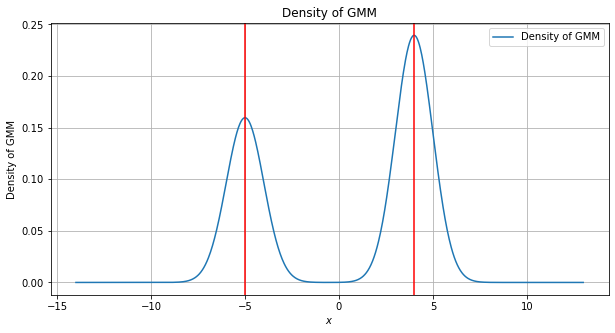

In [3]:
fig = experiment_default.plot_real_distribution()

In [4]:
data, component_choose = experiment_default.generate_noise_data()
print(data.shape)
print(data)
print(component_choose)
print(np.sum(component_choose))

(100,)
[ 4.12310314 -5.42286025 -4.87023067  1.18915308  3.68933704  4.50503344
  6.0900578  -5.73294477 -6.14338262 -5.70959162  5.29457409 -4.53507572
 -5.74919406  4.72586977  4.13728839  5.36987088  3.00714699  3.53661575
  3.44547533  1.93027731 -4.58122269  4.36918791  4.00723152  3.66824369
  1.9983635  -5.59488232  3.51532848  2.86540861  3.77190756  4.5714142
 -2.33253032  4.24689031  4.36423126 -5.10528242 -7.71355228 -5.03749628
  4.08517838  7.4835504  -5.27203949  4.42645234  3.95091014  2.34723967
  5.61619552 -3.93660611  5.11868811 -6.28606807  5.98385074  2.01748321
  4.82994126  7.09777205 -6.40082991 -5.80086593 -4.85907169 -5.7120221
  1.80703075 -4.90303731  2.49767568  4.66976084  2.69973778  6.19193826
  2.89231257  3.54453624 -3.84951292  2.25929499  4.32167692  5.84857901
  1.72667541 -4.73888829  4.36752977 -3.89433549 -6.74931247  2.13259235
  4.73813684 -4.58000025 -4.64574961 -4.51004824 -5.96170018  4.32845633
  4.41446707  2.98975454 -2.36139638 -4.329899

In [5]:
data, component_choose = experiment_default.generate_noise_data(random_state_data=30)
print(data)
print(component_choose)
print(np.sum(component_choose))

[-5.36760337  4.80085985 -3.59918969  3.15887767 -4.51427     0.33814496
 -5.0233378   3.90653365  3.81846348  2.73346245  4.81331099  3.29508991
  2.36615894 -3.72602171 -3.756961    1.88584122  3.5722093  -6.50443718
  6.41084359  5.24086802 -3.58216564 -6.47610597 -3.20673791  3.60116031
 -4.53093309  4.61809818  4.64350805  3.46267153  5.11146942  3.63437935
 -3.68174371  2.03314718  3.06866563  4.9950823   2.63989241 -3.64982586
  5.44433793  5.04472615  3.42062806  4.81653966  4.58913305 -4.2625559
  1.91593501  3.15543663  8.27162634  3.53881482 -5.80897422 -6.15255176
  4.84802508  3.47301714 -4.38100243  4.72705847  5.07224763 -4.42796778
 -7.66464077  4.51538637 -4.45586626  5.14980838  4.82041892  3.14313983
  4.3242609  -6.9348692   6.50987344  4.57316747 -4.77642734 -4.78130806
  3.22772769  2.79806104 -4.33074971  4.53756478  2.65098659 -6.5722009
  3.40135345  3.75662366  6.14526308 -3.24862073  3.45022942  3.85238681
  4.32316024  6.73424404 -6.30747636 -4.48142822  4.8

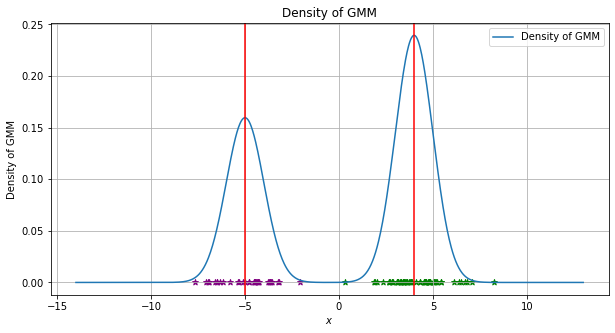

In [6]:
fig = experiment_default.plot_real_distribution_with_data(data, component_choose)

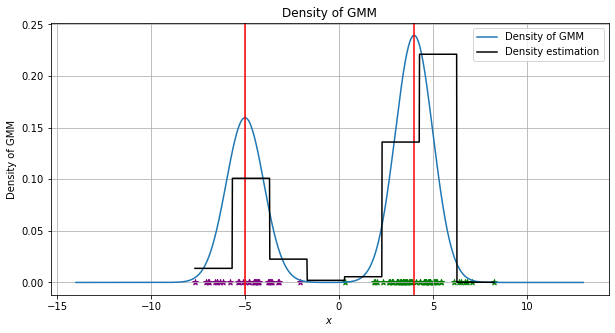

In [7]:
fig = experiment_default.plot_real_distribution_with_dens_estimation(data, component_choose, 
                                                                     eta_arr=eta_arr_default)

In [8]:
a, b = calculate_a_b(data)
phi = calculate_phi(a, b, eta_arr_default)
y_arr = np.linspace(a, b, num=1000, endpoint=False)
density_est_arr = np.array([dens_estimation(y, eta_arr_default, phi, a, b) for y in y_arr])
print(np.sum(np.unique(density_est_arr))*(b - a)/8)

0.9999999999999998


# Testing functions, J = 2

In [9]:
J = 2
print("-----------------------")
print("Function theta_from_GMM_params:")
print(f"p_arr = {p_arr_default}, mu_arr = {mu_arr_default}, sigma_arr = {sigma_arr_default}")
theta_default = theta_from_GMM_params(p_arr_default, mu_arr_default, sigma_arr_default)
print(f"theta = {theta_default}")
print("-----------------------")
print("Function GMM_params_from_theta:")
p_arr, mu_arr, sigma_arr = GMM_params_from_theta(theta_default)
print(f"p_arr = {p_arr}, mu_arr = {mu_arr}, sigma_arr = {sigma_arr}")
print("-----------------------")
print("Function index_to_jk:")
for i in range(7):
    print(f"{i} -> {index_to_jk(i)}")
print("-----------------------")
print("Function jk_to_index:")
for j in range(J + 1):
    for k in range(2**j):
        print(f"({j}, {k}) -> {jk_to_index(j, k)}")
print("-----------------------")
print("Function p:")
test_arr = np.array([-1, -0.5, 0.2, 0.4, 0.8, 0.9, 1.3])
for x in test_arr:
    print(f"p({x}) = {p(x)}")
print("-----------------------")
print("Function h:")
for x in test_arr:
    print(f"h({x}) = {h(x)}")
print("-----------------------")
print("Function convert_1d_eta_to_2d_eta:")
test_arr_eta = np.array([1, 2, 3, 4, 5, 6, 7, 8])
print(f"test array = {test_arr_eta}")
eta_2d, eta_0 = convert_1d_eta_to_2d_eta(test_arr_eta)
print(f"{eta_2d}, {eta_0}")
print("-----------------------")
print("Function convert_2d_eta_to_1d_eta:")
eta_arr = convert_2d_eta_to_1d_eta(eta_2d, eta_0)
print(f"{eta_arr}")
print("-----------------------")
experiment_default = Deconv1dExperiment()
data, component_choose = experiment_default.generate_noise_data()
a, b = calculate_a_b(data)
print("Function calculate_stupid_phi:")
print(f"phi = {calculate_stupid_phi(a, b, eta_arr)}")
print("-----------------------")
print("Function calculate_phi:")
print(f"phi = {calculate_phi(a, b, eta_arr)}")
print("-----------------------")
print("Function L:")
print(f"L = {L(eta_arr, data)}")
print("-----------------------")
print("Function calculate_gauss_int:")
mu = 2
sigma = 2
c = -10
d = 10
int_1 = calculate_gauss_int(c, d, mu, sigma)
int_2 = norm.cdf((d - mu)/sigma) - norm.cdf((c - mu)/sigma)
d = -9
int_3 = calculate_gauss_int(c, d, mu, sigma)
print(f"gauss_int/big = {int_1}, gauss_int/big/checking = {int_2},  gauss_int/small = {int_3}")
print("-----------------------")
print("Function calculate_int_of_conv:")
c = -15
d = 15
sigma_noise = sigma_noise_default
theta_arr = theta_default
int_4 = calculate_int_of_conv(c, d, theta_arr, sigma_noise)
c = -10
d = -9
int_5 = calculate_int_of_conv(c, d, theta_arr, sigma_noise)
print(f"convolution_int/big = {int_4}, convolution_int/small = {int_5}")
print("-----------------------")
print("Function calculate_int_of_sqr_conv:")
c = -13
d = 13
int_6 = calculate_int_of_sqr_conv(c, d, theta_arr, sigma_noise)
p_arr, mu_arr, sigma_arr = GMM_params_from_theta(theta_arr)
sigma_arr_noise = sigma_arr_with_noise(sigma_arr, sigma_noise)
first_part_limit = p_arr[0]**2/(2*((np.pi)**0.5*sigma_arr_noise[0]))
sigma_sum_noise_sqr = (sigma_arr[0]**2 + sigma_arr[1]**2 + 2*(sigma_noise**0.5))
second_part_limit = 2*p_arr[0]*p_arr[1]*np.exp(-((mu_arr[0] - mu_arr[1])**2)/(2*sigma_sum_noise_sqr))/(
    ((2*np.pi)**0.5 * sigma_sum_noise_sqr**0.5))
third_part_limit = p_arr[1]**2/(2*((np.pi)**0.5)*sigma_arr_noise[1])
limit = first_part_limit + second_part_limit + third_part_limit
c = -10
d = -9
int_7 = calculate_int_of_sqr_conv(c, d, theta_arr, sigma_noise)
print(f"conv_sqr_int/big = {int_6}, conv_sqr_int/limit = {limit}, conv_sqr_int/small = {int_7}")
print("-----------------------")
print("Function calculate_NCS:")
eta_arr = eta_arr_default
NCS = calculate_NCS(eta_arr, theta_arr, a, b, sigma_noise)
print(f"eta_arr = {eta_arr}, theta_arr = {theta_arr}, a = {a}, b = {b}, sigma_noise = {sigma_noise}")
print(f"Neiman's chi sqr distance = {NCS}")
print("-----------------------")
print("Function calculate_prior:")
eta_prior_term = calculate_prior(eta_arr, eta_0_default, experiment_default.eta_cov_inv)
theta_prior_term = calculate_prior(theta_arr, theta_0_default, experiment_default.theta_cov_inv)
print(f"eta_prior_term = {eta_prior_term}, theta_prior_term = {theta_prior_term}")
print("-----------------------")

-----------------------
Function theta_from_GMM_params:
p_arr = [0.6 0.4], mu_arr = [ 4. -5.], sigma_arr = [1. 1.]
theta = [ 0.40546511  4.         -5.          0.          0.        ]
-----------------------
Function GMM_params_from_theta:
p_arr = [0.6 0.4], mu_arr = [ 4. -5.], sigma_arr = [1. 1.]
-----------------------
Function index_to_jk:
0 -> (0, 0)
1 -> (1, 0)
2 -> (1, 1)
3 -> (2, 0)
4 -> (2, 1)
5 -> (2, 2)
6 -> (2, 3)
-----------------------
Function jk_to_index:
(0, 0) -> 0
(1, 0) -> 1
(1, 1) -> 2
(2, 0) -> 3
(2, 1) -> 4
(2, 2) -> 5
(2, 3) -> 6
-----------------------
Function p:
p(-1.0) = 0
p(-0.5) = 0
p(0.2) = 1
p(0.4) = 1
p(0.8) = 1
p(0.9) = 1
p(1.3) = 0
-----------------------
Function h:
h(-1.0) = 0
h(-0.5) = 0
h(0.2) = 1
h(0.4) = 1
h(0.8) = -1
h(0.9) = -1
h(1.3) = 0
-----------------------
Function convert_1d_eta_to_2d_eta:
test array = [1 2 3 4 5 6 7 8]
[array([1.]) array([2., 3.]) array([4., 5., 6., 7.])], 8
-----------------------
Function convert_2d_eta_to_1d_eta:
[1

# Testing Neiman's chi square distance

eta_arr = [-1.   1.  -1.  -1.   1.5 -1.   1.   0. ], theta_arr = [ 0.84729786 -1.         -8.          0.          0.        ], a = -10.713552275767011, b = 2.483550402885245, sigma_noise = 1.0
Function calculate_NCS:
Neiman's chi sqr distance = 32.76183404815875


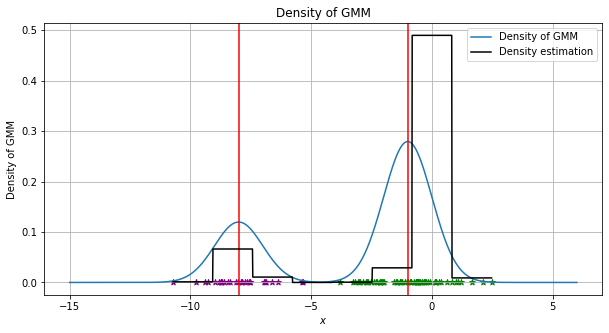

In [10]:
p_arr_bad = np.array([0.7, 0.3])
mu_arr_bad = np.array([-1, -8])
sigma_arr_bad = np.array([1, 1])
experiment_bad = Deconv1dExperiment(p_arr = p_arr_bad, mu_arr = mu_arr_bad,
                                     sigma_arr = sigma_arr_bad)
data, component_choose = experiment_bad.generate_noise_data()
a, b = calculate_a_b(data)
eta_arr_bad = np.array([-1, 1, -1, -1, 1.5, -1, 1, 0])
theta_arr_bad = theta_from_GMM_params(p_arr_bad, mu_arr_bad, sigma_arr_bad)
fig = experiment_bad.plot_real_distribution_with_dens_estimation(data, component_choose, eta_arr_bad)
sigma_noise = sigma_noise_default
print(f"eta_arr = {eta_arr_bad}, theta_arr = {theta_arr_bad}, a = {a}, b = {b}, sigma_noise = {sigma_noise}")
print("Function calculate_NCS:")
NCS = calculate_NCS(eta_arr_bad, theta_arr_bad, a, b, sigma_noise)
print(f"Neiman's chi sqr distance = {NCS}")

# Testing functions, J = 3

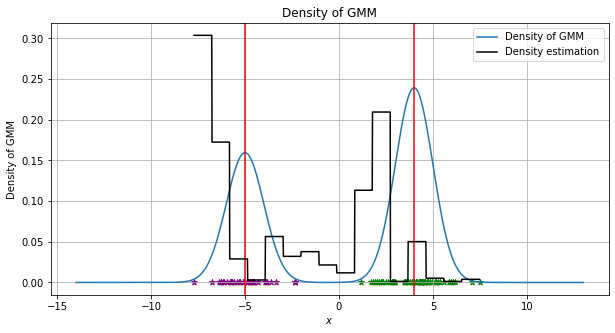

In [11]:
experiment_default = Deconv1dExperiment()
data, component_choose = experiment_default.generate_noise_data()
eta_arr_j_3 = np.array([0.6, 0.1, 0.5, 0.8, 0.1, 0.2, 0.5, 0.1, 0.4, 0.1, 0.1, -0.4, 0.9, 0.4, -0.2, 0])
fig = experiment_default.plot_real_distribution_with_dens_estimation(data, component_choose, 
                                                                     eta_arr=eta_arr_j_3)

# Final log-likelihood function

In [12]:
params = np.concatenate((eta_arr_default, theta_arr_default))
params = {'points': params}
print(f"params = {params}")
data_default = experiment_default.generate_noise_data()[0]
eta_cov_inv = experiment_default.eta_cov_inv
theta_cov_inv = experiment_default.theta_cov_inv
cur_posterior_log_likelihood = posterior_log_likelihood(calculate_log_likelihood, data_default,
                                                    J_default, 
                                                lambda_coef_default, dist_type_default,
                                                sigma_noise_default, eta_0_default, eta_cov_inv, 
                                                theta_0_default, theta_cov_inv)
log_likelihood = cur_posterior_log_likelihood(params)
print(f"log_likelihood = {log_likelihood}")

params = {'points': array([ 0.08      ,  0.6       ,  0.5       , -0.5       ,  0.6       ,
       -0.8       ,  1.75      ,  0.        ,  0.40546511,  4.        ,
       -5.        ,  0.        ,  0.        ])}
log_likelihood = -249.58972652938738


# Testing PyTorch functions

In [33]:
torch_params = torch.from_numpy(np.concatenate((eta_arr_default, theta_arr_default)))
params = torch_params.view(1, torch_params.shape[0])
params = {'points': params}
print(f"params = {params}")
params_dim = params['points'][0].shape[0]
eta_0_torch = torch.from_numpy(experiment_default.eta_0) 
eta_cov_inv_torch = torch.from_numpy(experiment_default.eta_cov_inv)
theta_0_torch = torch.from_numpy(experiment_default.theta_0)
theta_cov_inv_torch = torch.from_numpy(experiment_default.theta_cov_inv)
cur_posterior_log_likelihood_torch = posterior_log_likelihood_torch(calculate_log_likelihood_torch, 
                                                                    data = data_default, J = J_default, 
                                                                    lambda_coef = lambda_coef_default, 
                                                                    dist_type = dist_type_default,
                                                                    sigma_noise = sigma_noise_default, 
                                                                    eta_0 = eta_0_torch, 
                                                                    eta_cov_inv = eta_cov_inv_torch, 
                                                                    theta_0 = theta_0_torch, 
                                                                    theta_cov_inv = theta_cov_inv_torch)
log_likelihood_torch = cur_posterior_log_likelihood_torch(params)
print(f"log_likelihood_torch = {log_likelihood_torch.item()}")

params = {'points': tensor([[ 0.0800,  0.6000,  0.5000, -0.5000,  0.6000, -0.8000,  1.7500,  0.0000,
          0.4055,  4.0000, -5.0000,  0.0000,  0.0000]], dtype=torch.float64)}
log_likelihood_torch = -249.58970642089844


In [18]:
params_dim

13

In [34]:
potential_fn = potential_fn_MCMC(calculate_log_likelihood_torch, data = data_default, J = J_default, 
                                 lambda_coef = lambda_coef_default, dist_type = dist_type_default,
                                 sigma_noise = sigma_noise_default, eta_0 = eta_0_torch, 
                                 eta_cov_inv = eta_cov_inv_torch, theta_0 = theta_0_torch, 
                                 theta_cov_inv = theta_cov_inv_torch)
minus_log_likelihood_torch = potential_fn(params)
print(f"minus_log_likelihood_torch = {minus_log_likelihood_torch.item()}")

minus_log_likelihood_torch = 249.58970642089844


# MCMC, example

In [25]:
sampling_distr = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float64),
                                           scale=torch.tensor(1., dtype=torch.float64))
init_samples = sampling_distr.sample((params_dim, )).view(1, params_dim)
print(init_samples)
init_params = {'points': init_samples}

tensor([[-0.5054, -0.2312,  1.7420,  0.8285, -0.4389,  0.4555,  0.4853, -0.0470,
          1.4987,  0.4575,  0.1892,  0.0829,  0.3362]], dtype=torch.float64)


In [26]:
num_samples=100
kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(kernel=kernel, num_samples=num_samples, initial_params=init_params,
                    num_chains=1)

In [27]:
mcmc.run()

Sample: 100%|██████████| 200/200 [03:03,  1.09it/s, step size=2.26e-04, acc. prob=0.747]


In [36]:
target_samples = mcmc.get_samples()['points']
print(f"samples = {target_samples}")

samples = tensor([[[ 0.4828,  0.6801, -1.0244,  ..., -0.0616, -0.1434,  0.1916]],

        [[ 0.4828,  0.6800, -1.0252,  ..., -0.0616, -0.1434,  0.1916]],

        [[ 0.4828,  0.6799, -1.0263,  ..., -0.0616, -0.1434,  0.1916]],

        ...,

        [[ 0.4830,  0.6802, -1.0465,  ..., -0.0617, -0.1435,  0.1916]],

        [[ 0.4830,  0.6802, -1.0466,  ..., -0.0617, -0.1435,  0.1916]],

        [[ 0.4830,  0.6802, -1.0468,  ..., -0.0617, -0.1435,  0.1916]]],
       dtype=torch.float64)


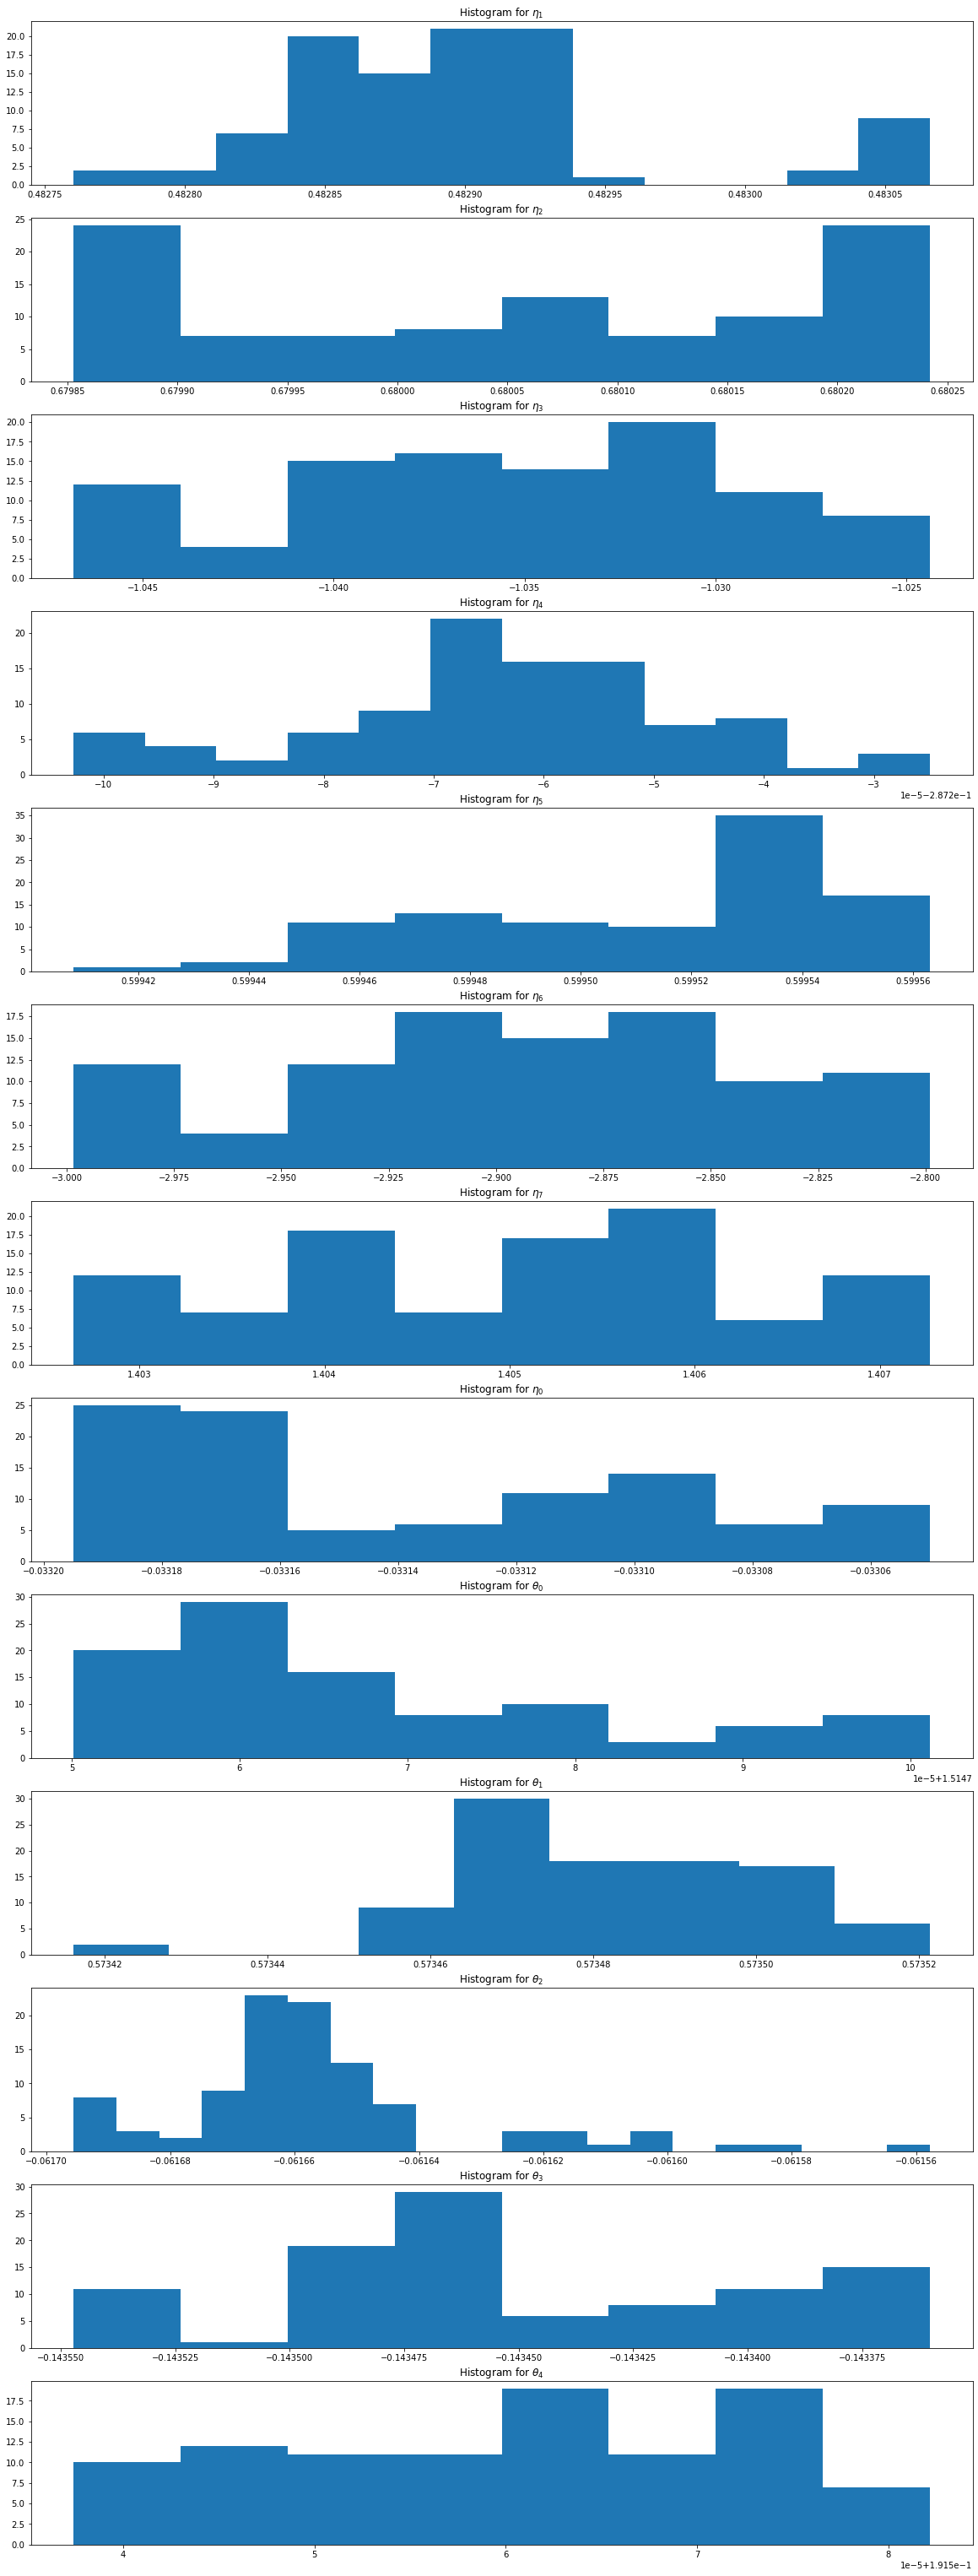

In [35]:
fig, axs = plt.subplots(params_dim, 1, figsize=(20, 55))
for i in range(params_dim):
    a = [target_samples[j][0][i].item() for j in range(num_samples)]
    axs[i].hist(a, bins='auto') 
    if (i < 2**(J + 1) - 1):
        axs[i].set_title(fr"Histogram for $\eta_{i + 1}$")
    if (i == 2**(J + 1) - 1):
        axs[i].set_title(fr"Histogram for $\eta_{0}$")
    if (i >= 2**(J + 1)):
        axs[i].set_title(fr"Histogram for $\theta_{i - 2**(J + 1)}$")
plt.show()

# MCMC for default params, num_samples = 1000

In [77]:
sampling_distr = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float64),
                                           scale=torch.tensor(0.01, dtype=torch.float64))
params_init_noise = sampling_distr.sample((params_dim, ))
torch_params = torch.from_numpy(np.concatenate((eta_arr_default, theta_arr_default)))
params_init = (torch_params + params_init_noise).view(1, params_dim)

In [78]:
torch_params

tensor([ 0.0800,  0.6000,  0.5000, -0.5000,  0.6000, -0.8000,  1.7500,  0.0000,
         0.4055,  4.0000, -5.0000,  0.0000,  0.0000], dtype=torch.float64)

In [79]:
params_init

tensor([[ 0.0973,  0.6044,  0.4899, -0.5145,  0.5982, -0.7969,  1.7336,  0.0098,
          0.3936,  4.0085, -4.9849, -0.0105,  0.0077]], dtype=torch.float64)

In [82]:
init_params = {'points': params_init}
print(f"Start loss = {potential_fn(init_params).item()}")

Start loss = 249.5860137939453


In [101]:
num_samples=1000
kernel = NUTS(potential_fn=potential_fn, step_size=1e-5)
mcmc = MCMC(kernel=kernel, num_samples=num_samples, initial_params=init_params,
                    num_chains=1, warmup_steps=num_samples)

In [102]:
mcmc.run()

Sample: 100%|██████████| 2000/2000 [59:05,  1.77s/it, step size=7.64e-05, acc. prob=0.568]


In [104]:
target_samples = mcmc.get_samples()['points']

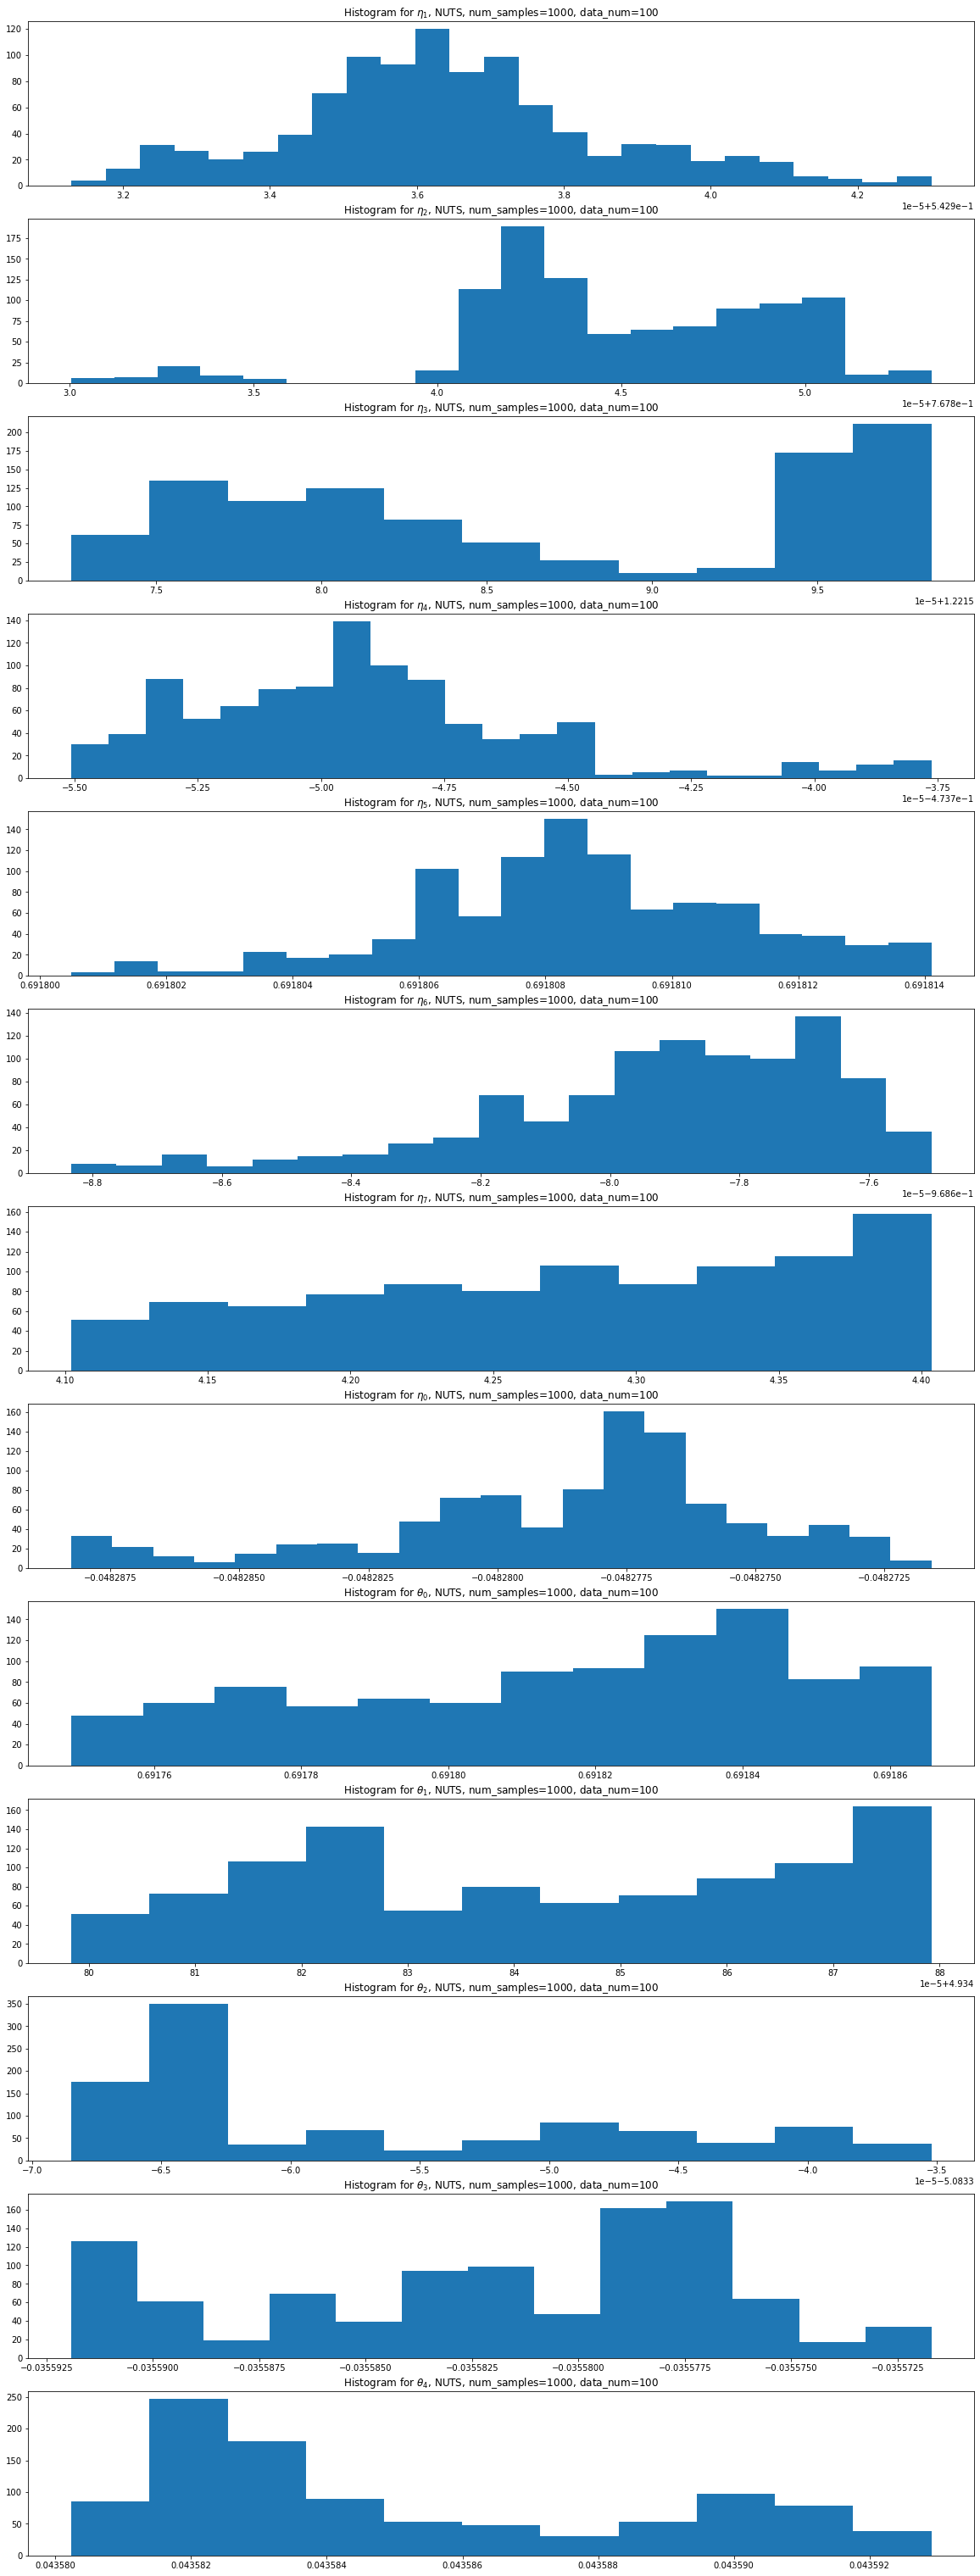

In [105]:
fig, axs = plt.subplots(params_dim, 1, figsize=(20, 55))
for i in range(params_dim):
    title_eta = fr"Histogram for $\eta_{i + 1}$, NUTS, num_samples={num_samples}, data_num={data_num_default}"
    title_eta_0 = fr"Histogram for $\eta_{0}$, NUTS, num_samples={num_samples}, data_num={data_num_default}"
    title_theta = fr"Histogram for $\theta_{i - 2**(J + 1)}$, NUTS, num_samples={num_samples}, "
    title_theta += fr"data_num={data_num_default}"
    theta_save_name = f'../arrays/2_nuts_num_samples_{num_samples}_theta_{i - 2**(J + 1)}' 
    theta_save_name += f'_data_num_{data_num_default}.npy'
    a = np.array([target_samples[j][0][i].item() for j in range(num_samples)])
    axs[i].hist(a, bins='auto') 
    if (i < 2**(J + 1) - 1):
        axs[i].set_title(title_eta)
        np.save(f'../arrays/2_nuts_num_samples_{num_samples}_eta_{i + 1}_data_num_{data_num_default}.npy', a)
    if (i == 2**(J + 1) - 1):
        axs[i].set_title(title_eta_0)
        np.save(f'../arrays/2_nuts_num_samples_{num_samples}_eta_0_data_num_{data_num_default}.npy', a)
    if (i >= 2**(J + 1)):
        axs[i].set_title(title_theta)
        np.save(theta_save_name, a)
plt.savefig(f'../figures/2_nuts_num_samples_{num_samples}_data_num_{data_num_default}.png')
plt.show()

In [20]:
b = np.load('../arrays/a.npy')

(array([  6.,  10.,   4.,   4.,   5.,  21.,  30.,  23.,  32.,  67., 134.,
        133., 106.,  94.,  48.,  45.,  55.,  44.,  32.,  36.,  29.,  17.,
          5.,   9.,   6.,   5.]),
 array([-0.07858546, -0.07858505, -0.07858463, -0.07858422, -0.0785838 ,
        -0.07858339, -0.07858297, -0.07858256, -0.07858215, -0.07858173,
        -0.07858132, -0.0785809 , -0.07858049, -0.07858008, -0.07857966,
        -0.07857925, -0.07857883, -0.07857842, -0.078578  , -0.07857759,
        -0.07857718, -0.07857676, -0.07857635, -0.07857593, -0.07857552,
        -0.07857511, -0.07857469]),
 <a list of 26 Patch objects>)

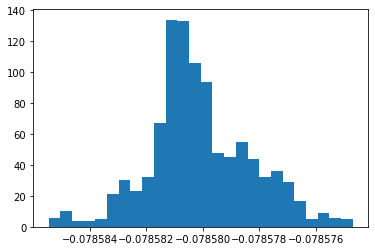

In [396]:
plt.hist(b, bins='auto') 

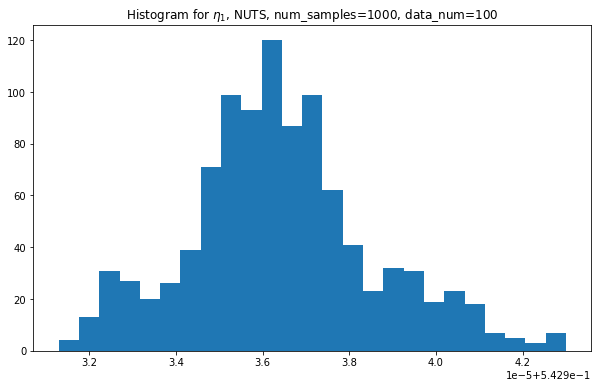

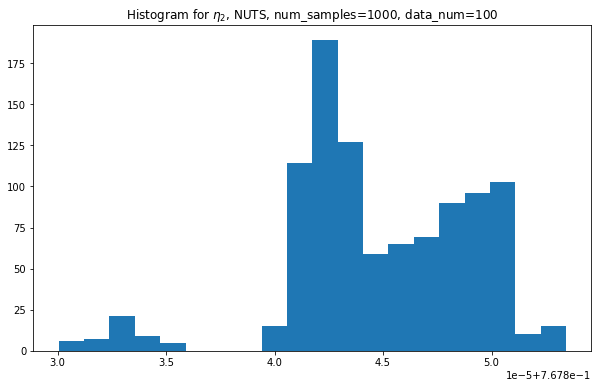

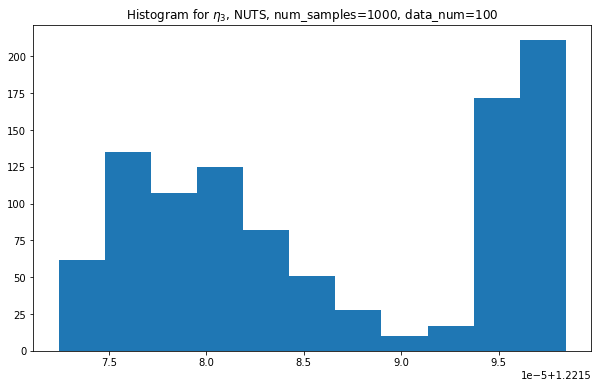

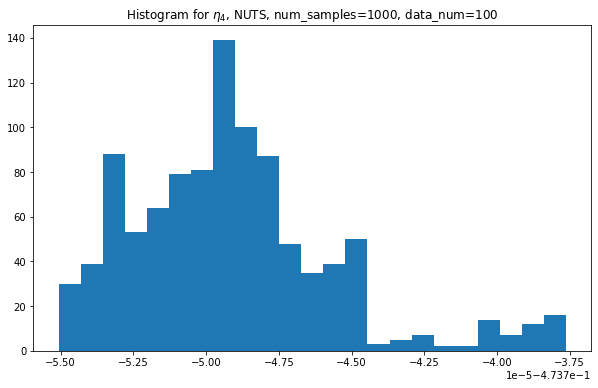

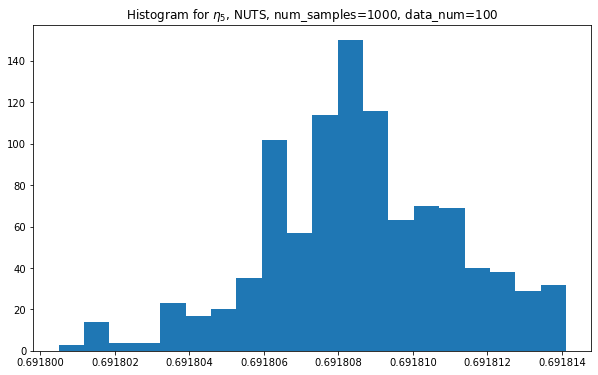

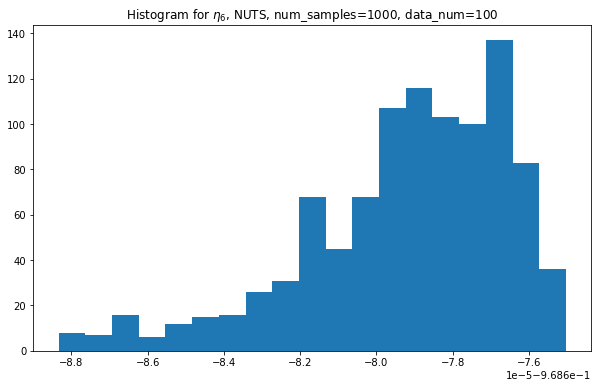

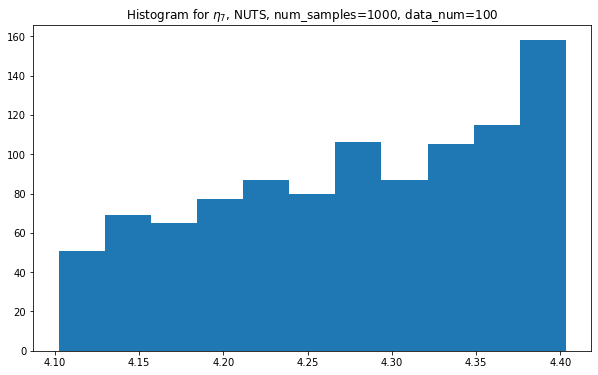

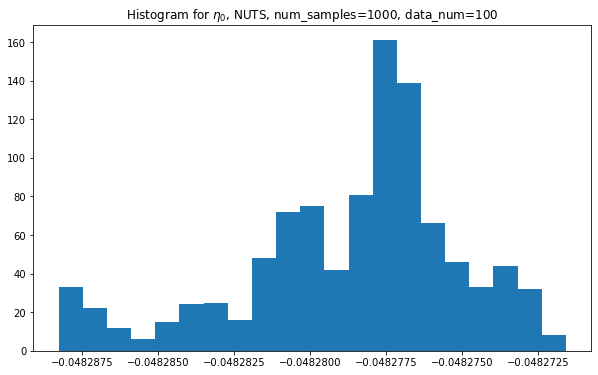

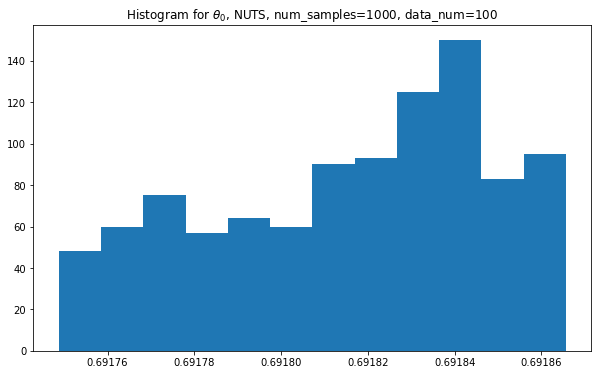

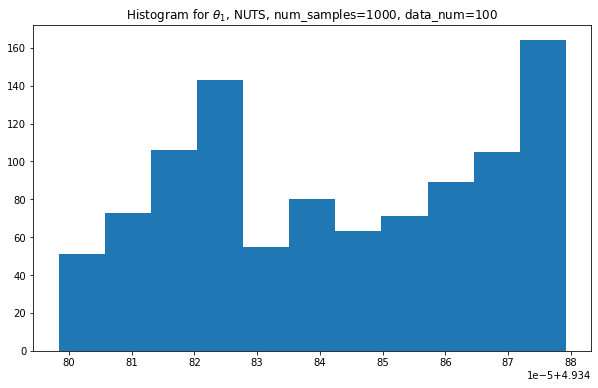

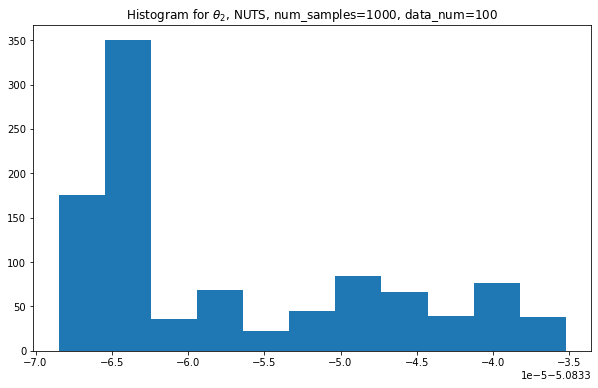

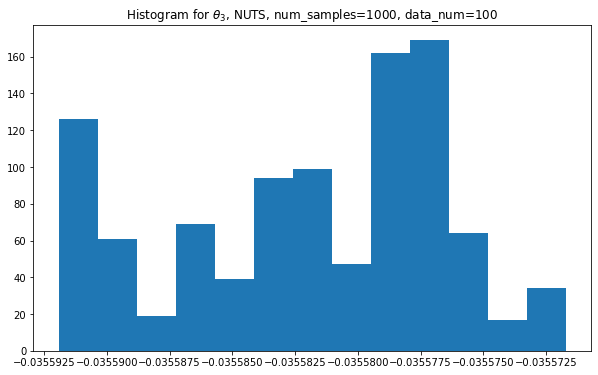

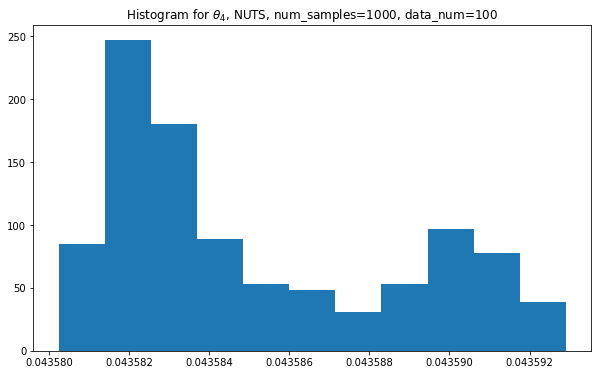

In [106]:
for i in range(params_dim):
    title_eta = fr"Histogram for $\eta_{i + 1}$, NUTS, num_samples={num_samples}, data_num={data_num_default}"
    title_eta_0 = fr"Histogram for $\eta_{0}$, NUTS, num_samples={num_samples}, data_num={data_num_default}"
    title_theta = fr"Histogram for $\theta_{i - 2**(J + 1)}$, NUTS, num_samples={num_samples}, "
    title_theta += fr"data_num={data_num_default}"
    eta_save_name = f'../figures/2_nuts_num_samples_{num_samples}_eta_{i}' 
    eta_save_name += f'_data_num_{data_num_default}.png'
    eta_0_save_name = f'../figures/2_nuts_num_samples_{num_samples}_eta_0' 
    eta_0_save_name += f'_data_num_{data_num_default}.png'
    theta_save_name = f'../figures/2_nuts_num_samples_{num_samples}_theta_{i - 2**(J + 1)}' 
    theta_save_name += f'_data_num_{data_num_default}.png'
    fig = plt.figure(figsize=(10, 6))
    a = np.array([target_samples[j][0][i].item() for j in range(num_samples)])
    plt.hist(a, bins='auto') 
    if (i < 2**(J + 1) - 1):
        plt.title(title_eta)
        plt.savefig(eta_save_name)
    if (i == 2**(J + 1) - 1):
        plt.title(title_eta_0)
        plt.savefig(eta_0_save_name)
    if (i >= 2**(J + 1)):
        plt.title(title_theta)
        plt.savefig(theta_save_name)
plt.show()

In [107]:
params_arr_download = []

for i in range(params_dim):
    if (i < 2**(J + 1)):
        cur_eta = np.load(f'../arrays/2_nuts_num_samples_1000_eta_{i}_data_num_{data_num_default}.npy')
        params_arr_download.append(cur_eta)
    else:
        theta_name_arr=f'../arrays/2_nuts_num_samples_1000_theta_{i - 2**(J + 1)}_data_num_{data_num_default}.npy'
        cur_theta = np.load(theta_name_arr)
        params_arr_download.append(cur_theta)

In [108]:
minus_log_likelihood_arr = []
for i in range(num_samples):
    cur_params = np.array([params_arr_download[j][i] for j in range(params_dim)])
    #print(cur_params)
    torch_params = torch.from_numpy(cur_params)
    params = torch_params.view(1, torch_params.shape[0])
    params = {'points': params}
    minus_log_likelihood = calculate_minus_log_likelihood_torch(params).item()
    minus_log_likelihood_arr.append(minus_log_likelihood)

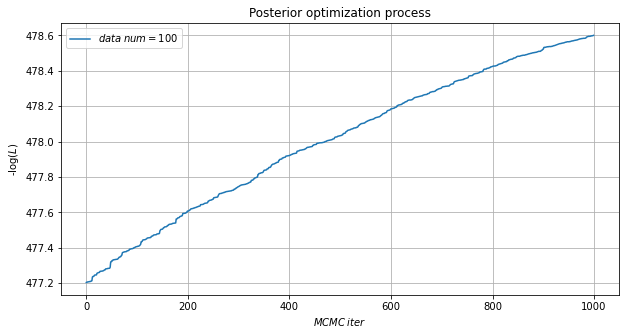

In [109]:
start_minus_log_likelihood = calculate_minus_log_likelihood_torch(init_params).item()

fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$MCMC \; iter$') 
plt.ylabel('-$\log(L)$') 
plt.title('Posterior optimization process') 

plt.plot([i for i in range(num_samples)], 
         minus_log_likelihood_arr, label = fr'$data \; num = {data_num_default}$')
#plt.plot([i for i in range(num_samples)],
#         [start_minus_log_likelihood for i in range(num_samples)], label='initial params', c = 'red')

plt.legend()
plt.grid(True) 
plt.savefig(f"../figures/2_posterior_optimization_num_samples_{num_samples}_data_num_{data_num_default}.png")
plt.show()

In [98]:
start_minus_log_likelihood

249.5860137939453

# MCMC for random params, num_samples = 100

In [22]:
sampling_distr = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float64),
                                           scale=torch.tensor(0.1, dtype=torch.float64))
params_init_noise = sampling_distr.sample((params_dim, ))
params_init = params_init_noise.view(1, params_dim)
print(params_init)

tensor([[-0.0593, -0.1144, -0.1324,  0.0525,  0.0641,  0.1116, -0.0828, -0.2162,
         -0.0054,  0.1700, -0.1308, -0.0788, -0.1192]], dtype=torch.float64)


In [23]:
init_params = {'points': params_init}
num_samples=100
kernel = NUTS(potential_fn=calculate_minus_log_likelihood_torch)
mcmc = MCMC(kernel=kernel, num_samples=num_samples, initial_params=init_params,
                    num_chains=1)

In [24]:
mcmc.run()

Sample: 100%|██████████| 200/200 [02:30,  1.33it/s, step size=5.16e-04, acc. prob=0.869]


In [25]:
target_samples = mcmc.get_samples()['points']

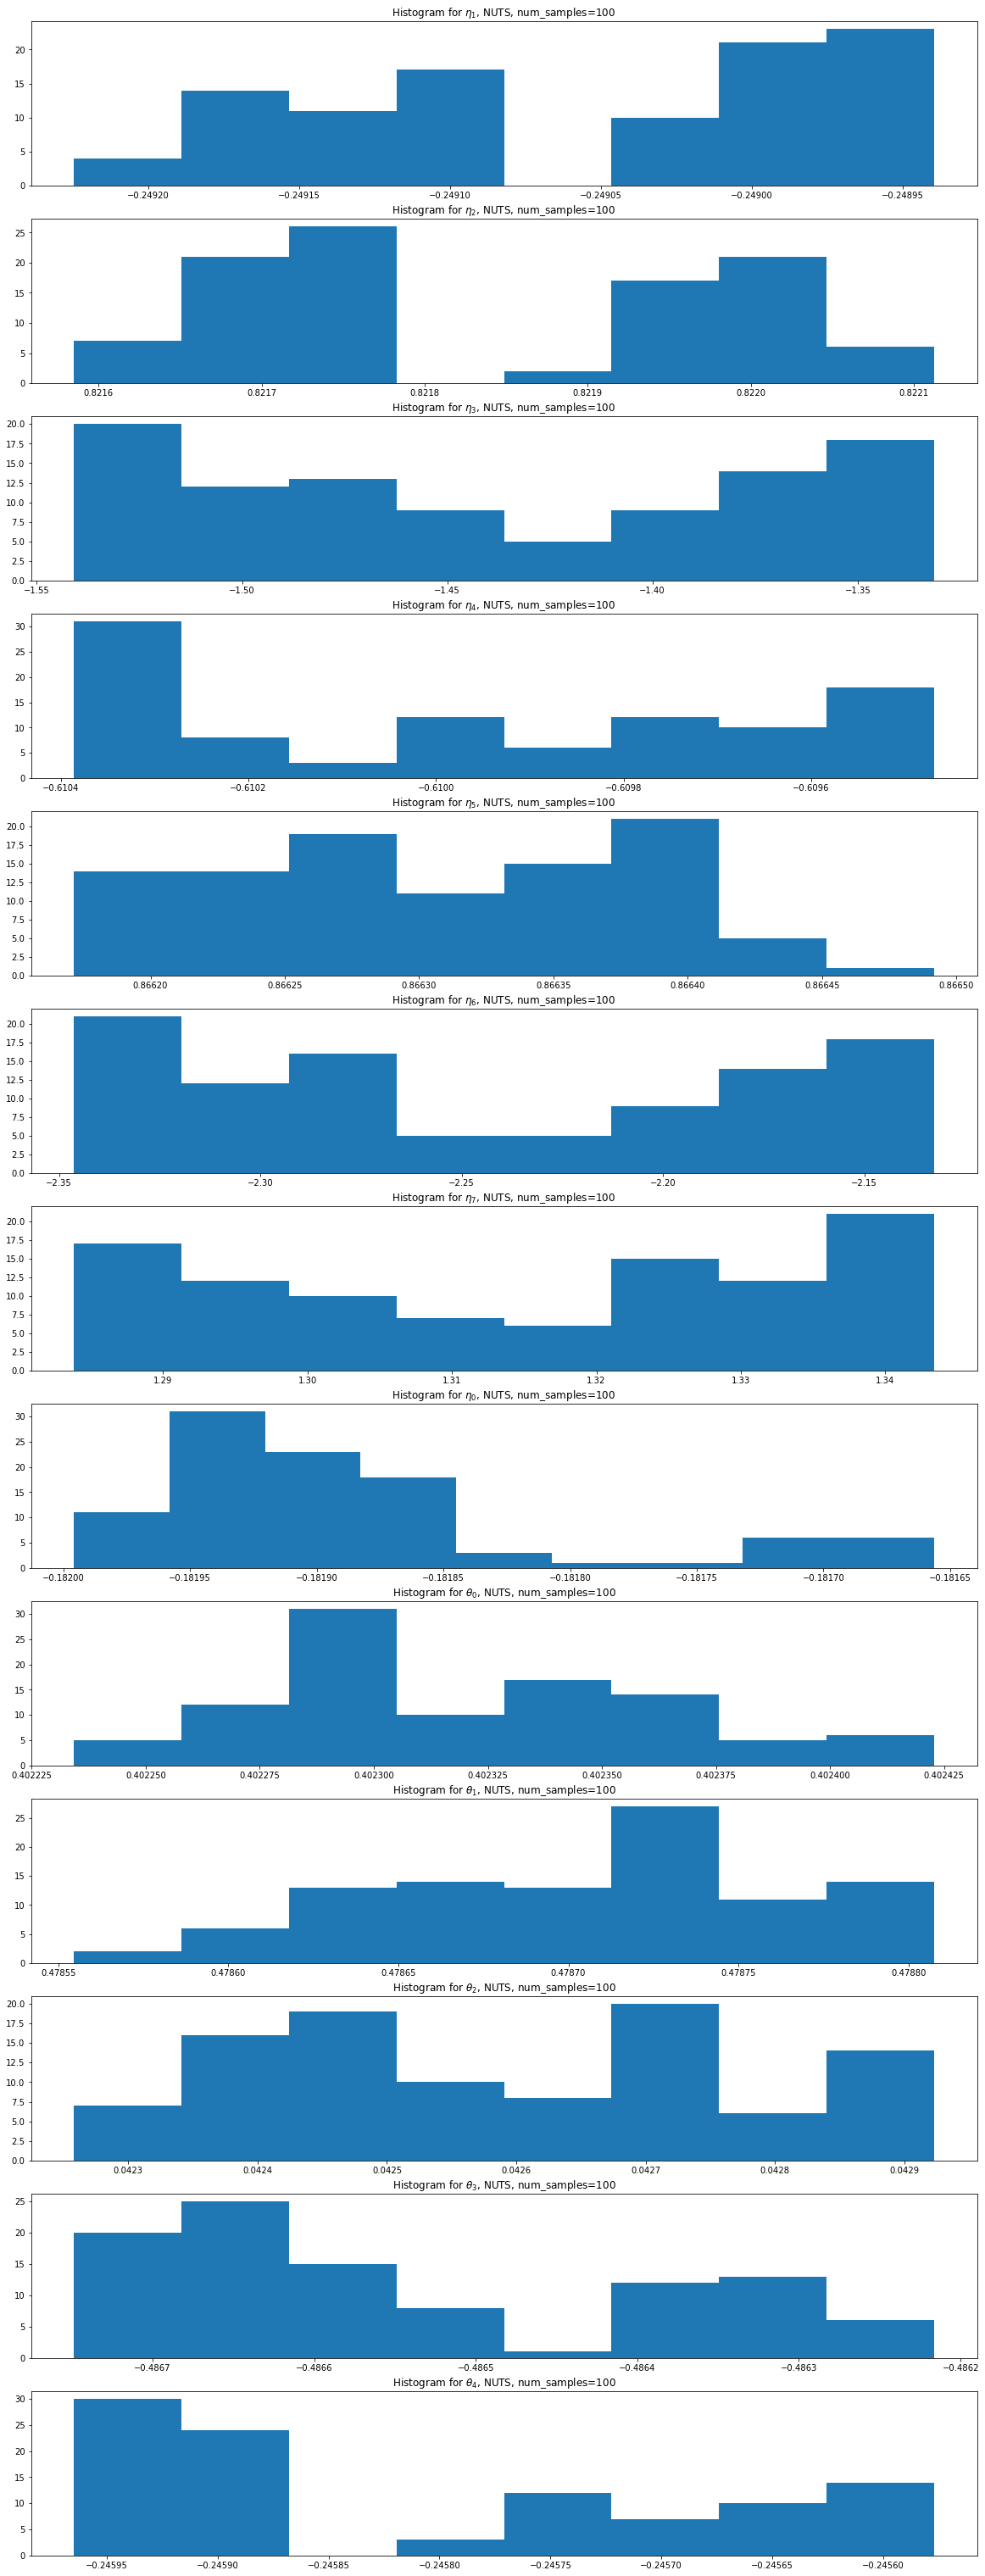

In [26]:
fig, axs = plt.subplots(params_dim, 1, figsize=(20, 55))
for i in range(params_dim):
    a = np.array([target_samples[j][0][i].item() for j in range(num_samples)])
    axs[i].hist(a, bins='auto') 
    if (i < 2**(J + 1) - 1):
        axs[i].set_title(fr"Histogram for $\eta_{i + 1}$, NUTS, num_samples={num_samples}")
        np.save(fr'../arrays/nuts_num_samples_{num_samples}_eta_{i + 1}.npy', a)
    if (i == 2**(J + 1) - 1):
        axs[i].set_title(fr"Histogram for $\eta_{0}$, NUTS, num_samples={num_samples}")
        np.save(fr'../arrays/nuts_num_samples_{num_samples}_eta_{0}.npy', a)
    if (i >= 2**(J + 1)):
        axs[i].set_title(fr"Histogram for $\theta_{i - 2**(J + 1)}$, NUTS, num_samples={num_samples}")
        np.save(fr'../arrays/nuts_num_samples_{num_samples}_theta_{i - 2**(J + 1)}.npy', a)
plt.savefig(f'../figures/nuts_num_samples_{num_samples}.png')
plt.show()

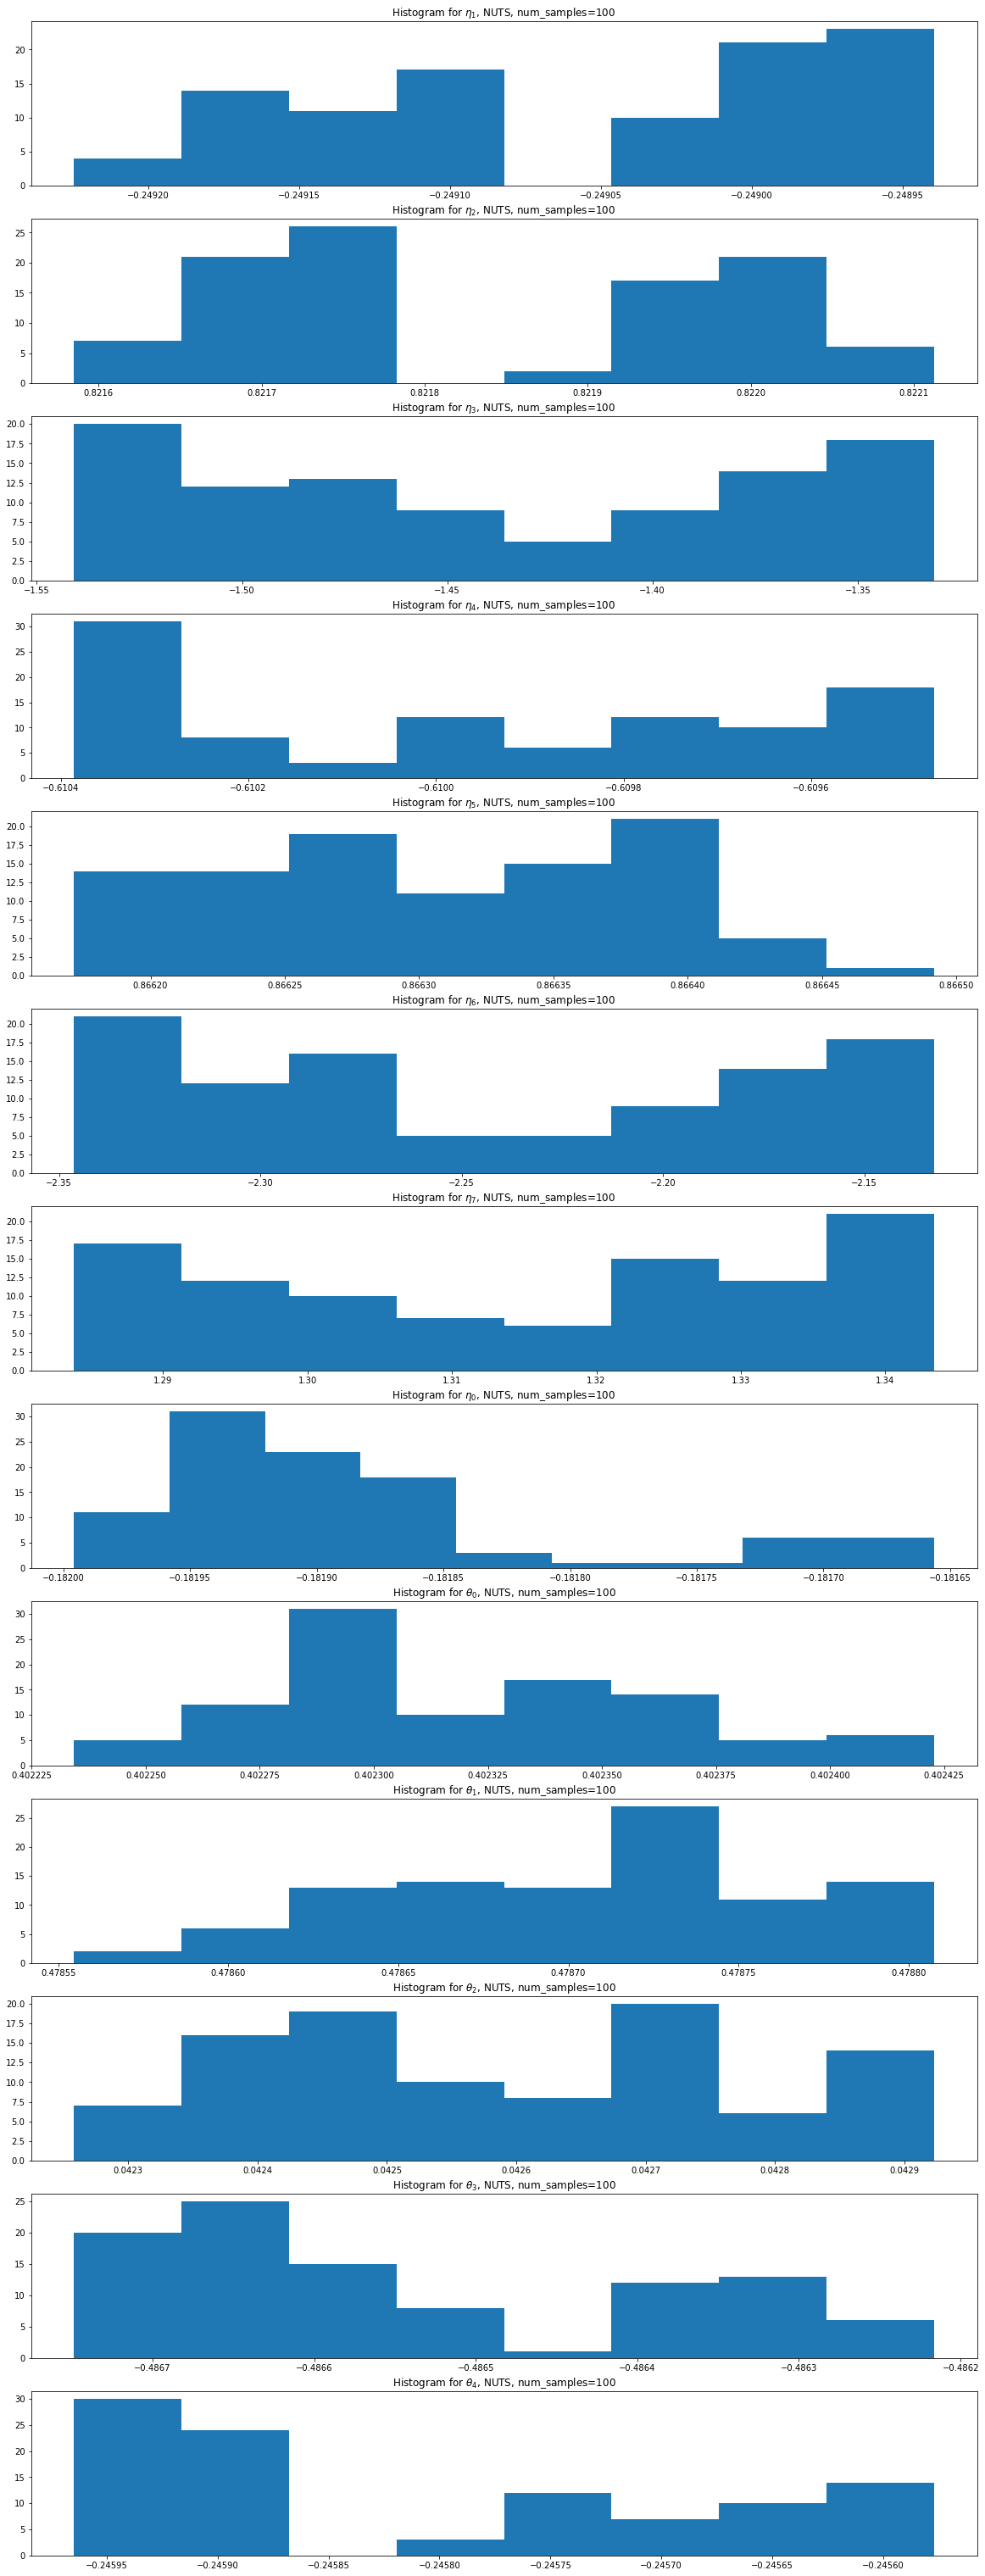

In [27]:
fig, axs = plt.subplots(params_dim, 1, figsize=(20, 55))
for i in range(params_dim):
    a = np.array([target_samples[j][0][i].item() for j in range(num_samples)])
    axs[i].hist(a, bins='auto') 
    if (i < 2**(J + 1) - 1):
        axs[i].set_title(fr"Histogram for $\eta_{i + 1}$, NUTS, num_samples={num_samples}")
        np.save(f'../arrays/nuts_num_samples_{num_samples}_eta_{i + 1}.npy', a)
    if (i == 2**(J + 1) - 1):
        axs[i].set_title(fr"Histogram for $\eta_{0}$, NUTS, num_samples={num_samples}")
        np.save(f'../arrays/nuts_num_samples_{num_samples}_eta_0.npy', a)
    if (i >= 2**(J + 1)):
        axs[i].set_title(fr"Histogram for $\theta_{i - 2**(J + 1)}$, NUTS, num_samples={num_samples}")
        np.save(f'../arrays/nuts_num_samples_{num_samples}_theta_{i - 2**(J + 1)}.npy', a)
plt.savefig(f'../figures/nuts_num_samples_{num_samples}.png')
plt.show()

In [30]:
b = np.load('../arrays/nuts_num_samples_100_theta_4.npy')

(array([30., 24.,  0.,  3., 12.,  7., 10., 14.]),
 array([-0.24596466, -0.24591623, -0.2458678 , -0.24581937, -0.24577093,
        -0.2457225 , -0.24567407, -0.24562564, -0.2455772 ]),
 <a list of 8 Patch objects>)

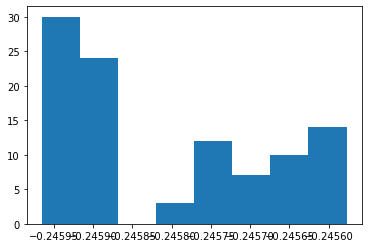

In [31]:
plt.hist(b, bins='auto') 

# More data, data_num = 1000

In [33]:
data_1000_num = 1000
data_1000_potential_fn = partial(calculate_minus_log_likelihood_torch, 
                  data = Deconv1dExperiment().generate_noise_data(data_num = data_1000_num)[0])

In [48]:
torch_params = torch.from_numpy(np.concatenate((eta_arr_default, theta_arr_default)))
init_params = torch_params.view(1, torch_params.shape[0])
init_params = {'points': init_params}
print(f"params = {init_params}")
params_dim = init_params['points'][0].shape[0]
minus_log_likelihood = data_1000_potential_fn(init_params)
print(f"minus_log_likelihood = {minus_log_likelihood}")

params = {'points': tensor([[ 0.0800,  0.6000,  0.5000, -0.5000,  0.6000, -0.8000,  1.7500,  0.0000,
          0.4055,  4.0000, -5.0000,  0.0000,  0.0000]], dtype=torch.float64)}
minus_log_likelihood = tensor([2811.0674])


In [36]:
init_params = {'points': params_init}
num_samples=100
kernel = NUTS(potential_fn=data_1000_potential_fn)
mcmc = MCMC(kernel=kernel, num_samples=num_samples, initial_params=params,
                    num_chains=1)

In [46]:
params

{'points': tensor([[ 0.4808,  0.3335, -1.3807, -0.6696,  1.0553, -2.9137,  0.7009, -1.0857,
           1.9492,  1.3681, -3.9137, -2.1736,  0.7412]], dtype=torch.float64)}

In [37]:
mcmc.run()

Sample: 100%|██████████| 200/200 [31:54,  9.57s/it, step size=8.15e-05, acc. prob=0.818]


In [38]:
target_samples_data_1000 = mcmc.get_samples()['points']

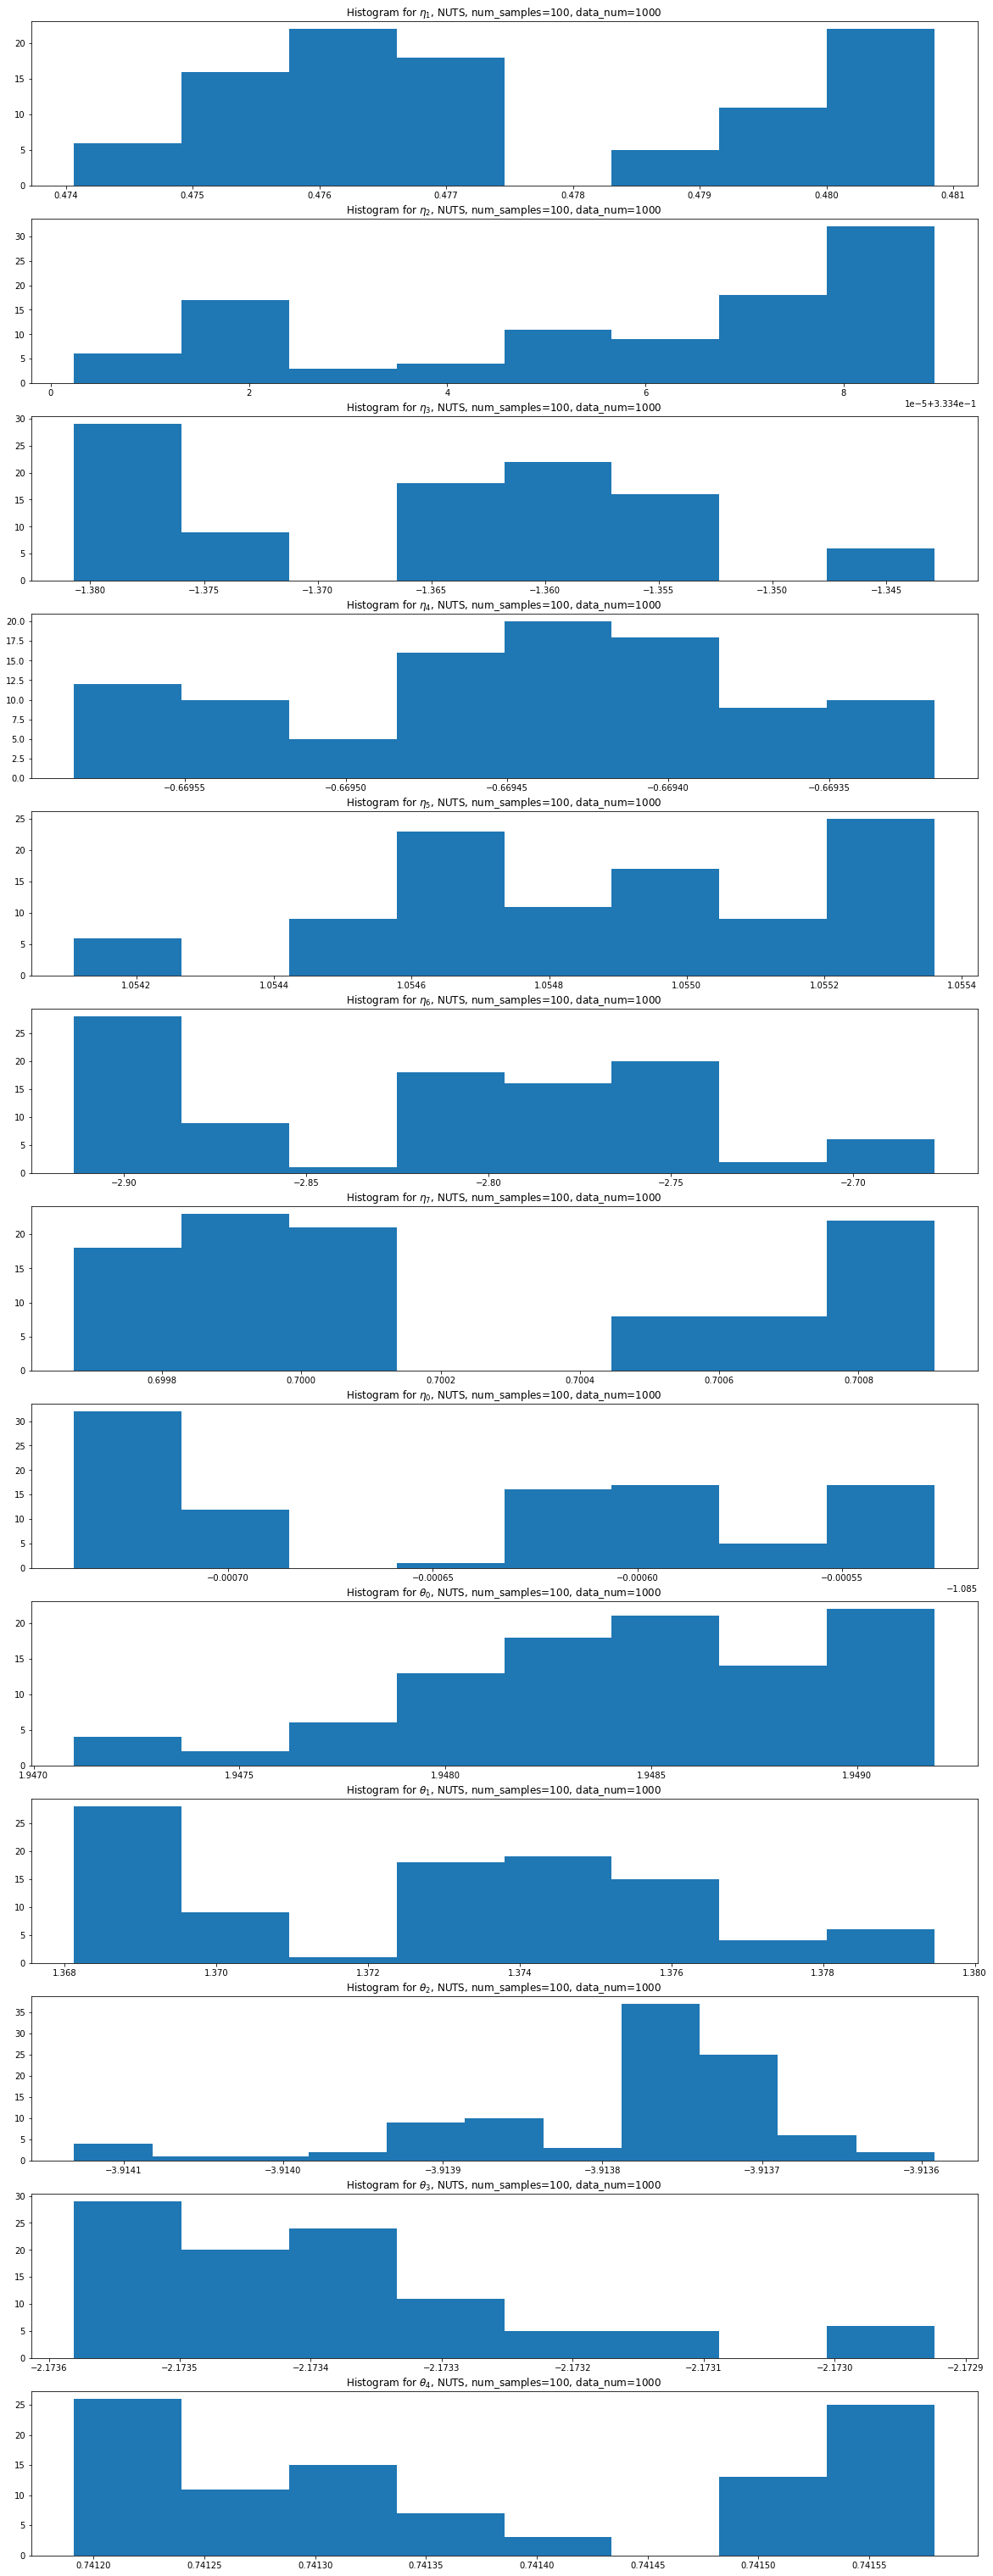

In [40]:
fig, axs = plt.subplots(params_dim, 1, figsize=(20, 55))
for i in range(params_dim):
    a = np.array([target_samples_data_1000[j][0][i].item() for j in range(num_samples)])
    axs[i].hist(a, bins='auto') 
    title_eta = fr"Histogram for $\eta_{i + 1}$, NUTS, num_samples={num_samples}, data_num={data_1000_num}"
    title_eta_0 = fr"Histogram for $\eta_{0}$, NUTS, num_samples={num_samples}, data_num={data_1000_num}"
    title_theta = fr"Histogram for $\theta_{i - 2**(J + 1)}$, NUTS, num_samples={num_samples}, "
    title_theta += fr"data_num={data_1000_num}"
    if (i < 2**(J + 1) - 1):
        axs[i].set_title(title_eta)
        np.save(fr'../arrays/nuts_num_samples_{num_samples}_eta_{i + 1}_data_num_{data_1000_num}.npy', a)
    if (i == 2**(J + 1) - 1):
        axs[i].set_title(title_eta_0)
        np.save(fr'../arrays/nuts_num_samples_{num_samples}_eta_{0}_data_num_{data_1000_num}.npy', a)
    if (i >= 2**(J + 1)):
        axs[i].set_title(title_theta)
        theta_ind = i - 2**(J + 1)
        np.save(fr'../arrays/nuts_num_samples_{num_samples}_theta_{theta_ind}_data_num_{data_1000_num}.npy', a)
plt.savefig(f'../figures/nuts_num_samples_{num_samples}_data_num_{data_1000_num}.png')
plt.show()

In [43]:
minus_log_likelihood_arr = []
for i in range(num_samples):
    cur_params = np.array([target_samples_data_1000[i][0][j].item() for j in range(params_dim)])
    torch_params = torch.from_numpy(cur_params)
    params = torch_params.view(1, torch_params.shape[0])
    params = {'points': params}
    minus_log_likelihood = calculate_minus_log_likelihood_torch(params).item()
    minus_log_likelihood_arr.append(minus_log_likelihood)

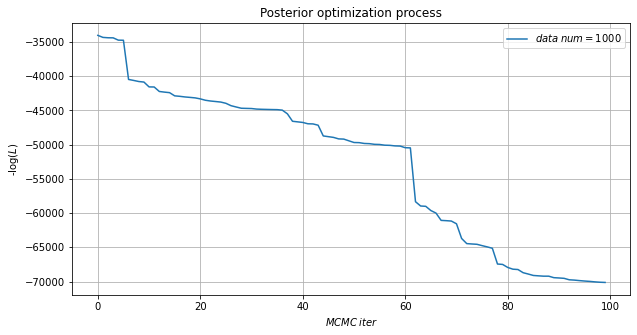

In [49]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$MCMC \; iter$') 
plt.ylabel('-$\log(L)$') 
plt.title('Posterior optimization process') 

plt.plot([i for i in range(num_samples)], minus_log_likelihood_arr, label = fr'$data \; num = {data_1000_num}$')

plt.legend()
plt.grid(True) 
plt.show()

# More complex model, J = 3, num_samples = 100, data_num = 100

In [24]:
J = 3
eta_J_3_default = np.zeros(2**(J + 1), dtype=np.float64)
eta_J_3_size = eta_J_3_default.shape[0]
np.random.seed(random_state_eta_default)
eta_0_J_3_default = torch.from_numpy(eta_J_3_default + sigma_eta_0_default_noise*np.random.randn(eta_J_3_size))
eta_cov_J_3_default = (sigma_gamma**2)*np.eye(eta_J_3_size)
J_3_potential_fn = partial(calculate_minus_log_likelihood_torch, J = J, eta_0 = eta_0_J_3_default,
                          eta_cov_inv = torch.from_numpy(Deconv1dExperiment(
                              eta_cov = eta_cov_J_3_default).eta_cov_inv))

In [29]:
J = 3
eta_J_3_default = np.zeros(2**(J + 1))
torch_params = torch.from_numpy(np.concatenate((eta_J_3_default, theta_arr_default)))
init_params = torch_params.view(1, torch_params.shape[0])
init_params = {'points': init_params}
print(f"params = {init_params}")
params_dim = init_params['points'][0].shape[0]
minus_log_likelihood = J_3_potential_fn(init_params)
print(f"minus_log_likelihood = {minus_log_likelihood}")

params = {'points': tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.4055,  4.0000, -5.0000,  0.0000,  0.0000]], dtype=torch.float64)}
minus_log_likelihood = tensor([277.9886])


In [121]:
num_samples=100
kernel = NUTS(potential_fn=J_3_potential_fn)
mcmc = MCMC(kernel=kernel, num_samples=num_samples, initial_params=init_params,
                    num_chains=1)

In [122]:
mcmc.run()

Sample: 100%|██████████| 200/200 [1:53:17, 33.99s/it, step size=2.80e-04, acc. prob=0.838]


In [126]:
target_samples_J_3 = mcmc.get_samples()['points']

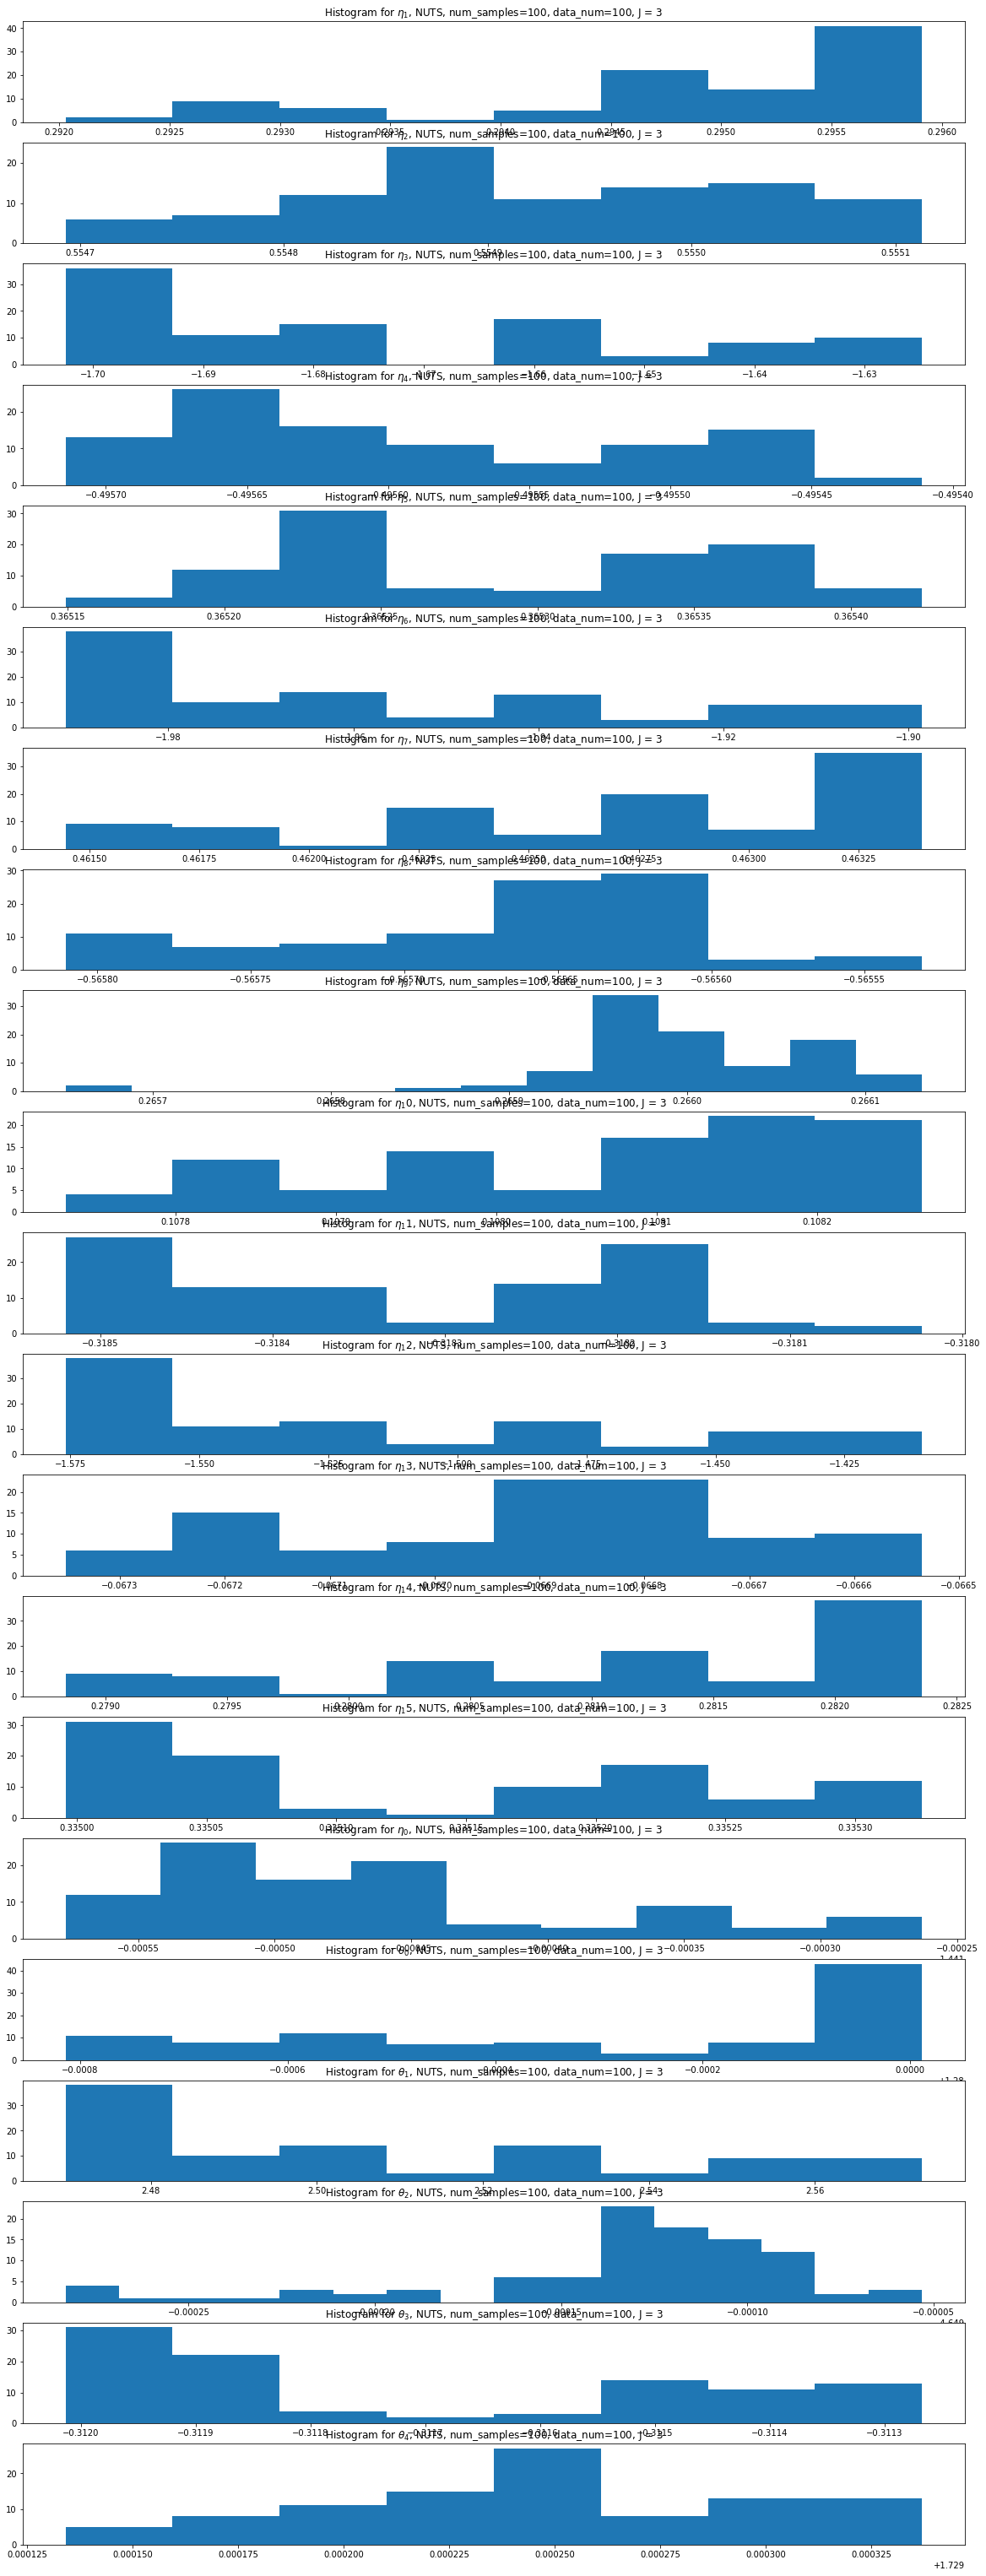

In [127]:
fig, axs = plt.subplots(params_dim, 1, figsize=(20, 55))
for i in range(params_dim):
    title_eta = fr"Histogram for $\eta_{i + 1}$, NUTS, num_samples={num_samples}, data_num={data_num_default}, J = {J}"
    title_eta_0 = fr"Histogram for $\eta_{0}$, NUTS, num_samples={num_samples}, data_num={data_num_default}, J = {J}"
    title_theta = fr"Histogram for $\theta_{i - 2**(J + 1)}$, NUTS, num_samples={num_samples}, "
    title_theta += fr"data_num={data_num_default}, J = {J}"
    theta_save_name = f'../arrays/nuts_num_samples_{num_samples}_theta_{i - 2**(J + 1)}' 
    theta_save_name += f'_data_num_{data_num_default}_J_{J}.npy'
    a = np.array([target_samples_J_3[j][0][i].item() for j in range(num_samples)])
    axs[i].hist(a, bins='auto') 
    if (i < 2**(J + 1) - 1):
        axs[i].set_title(title_eta)
        np.save(f'../arrays/nuts_num_samples_{num_samples}_eta_{i + 1}_data_num_{data_num_default}_J_{J}.npy', a)
    if (i == 2**(J + 1) - 1):
        axs[i].set_title(title_eta_0)
        np.save(f'../arrays/nuts_num_samples_{num_samples}_eta_0_data_num_{data_num_default}_J_{J}.npy', a)
    if (i >= 2**(J + 1)):
        axs[i].set_title(title_theta)
        np.save(theta_save_name, a)
plt.savefig(f'../figures/nuts_num_samples_{num_samples}_data_num_{data_num_default}_J_{J}.png')
plt.show()

In [128]:
minus_log_likelihood_arr = []
for i in range(num_samples):
    cur_params = np.array([target_samples_J_3[i][0][j].item() for j in range(params_dim)])
    torch_params = torch.from_numpy(cur_params)
    params = torch_params.view(1, torch_params.shape[0])
    params = {'points': params}
    minus_log_likelihood = J_3_potential_fn(params).item()
    minus_log_likelihood_arr.append(minus_log_likelihood)

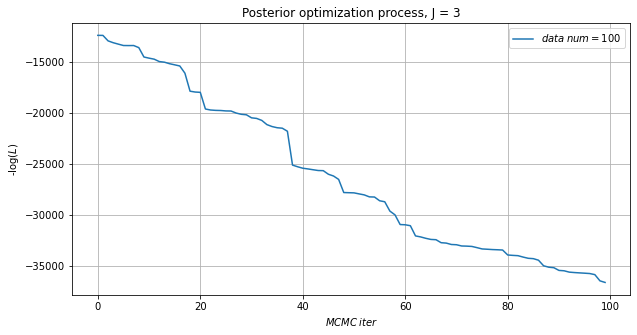

In [134]:
fig = plt.figure(figsize=(10,5))

plt.xlabel(r'$MCMC \; iter$') 
plt.ylabel('-$\log(L)$') 
plt.title(f'Posterior optimization process, J = {J}') 

plt.plot([i for i in range(num_samples)], minus_log_likelihood_arr, 
         label = fr'$data \; num = {data_num_default}$')

plt.legend()
plt.grid(True) 
plt.show()

In [130]:
start_minus_log_likelihood = J_3_potential_fn(init_params).item()

In [131]:
start_minus_log_likelihood

277.98858642578125

In [133]:
cur_params = np.array([target_samples_J_3[0][0][j].item() for j in range(params_dim)])
torch_params = torch.from_numpy(cur_params)
params = torch_params.view(1, torch_params.shape[0])
params = {'points': params}
J_3_potential_fn(params )

tensor([-12403.3164])

In [27]:
num_samples = 100

<ipython-input-31-3938c3f1664b>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 6))


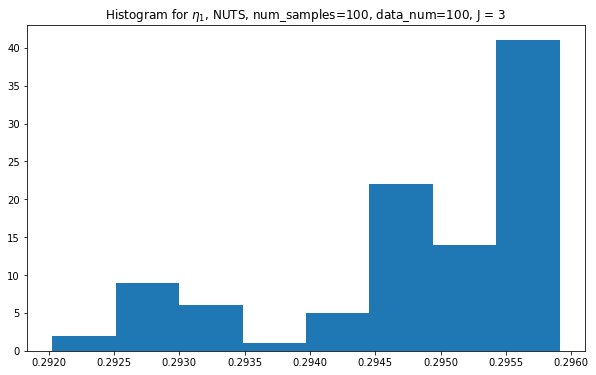

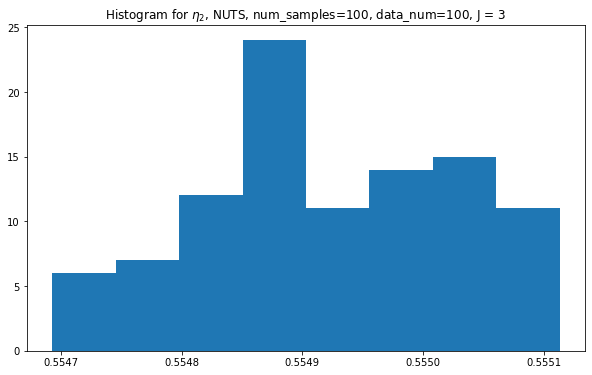

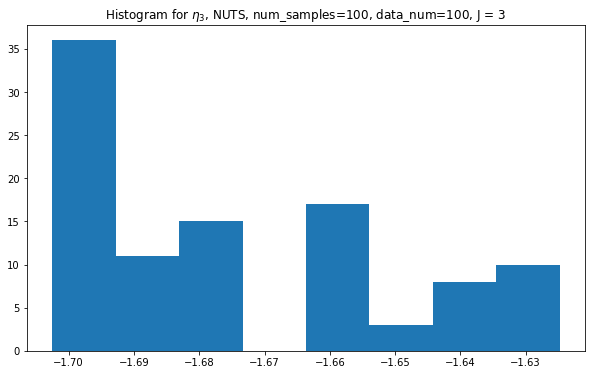

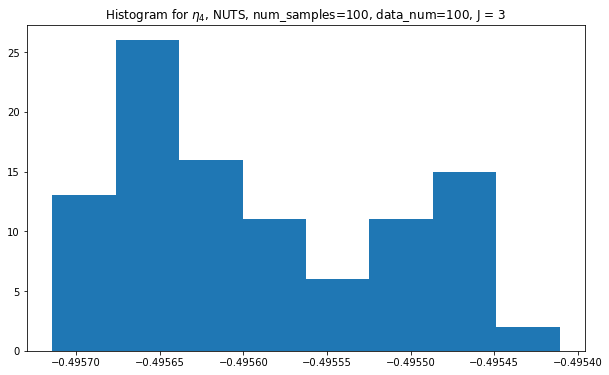

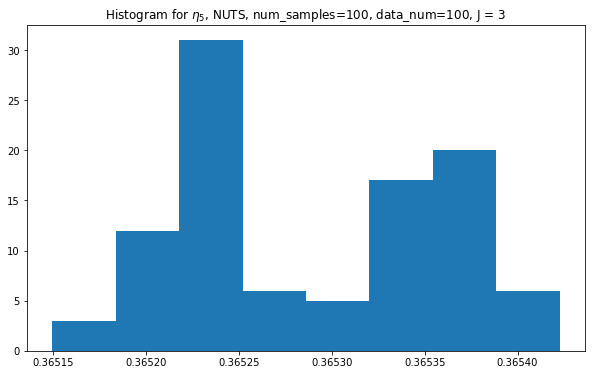

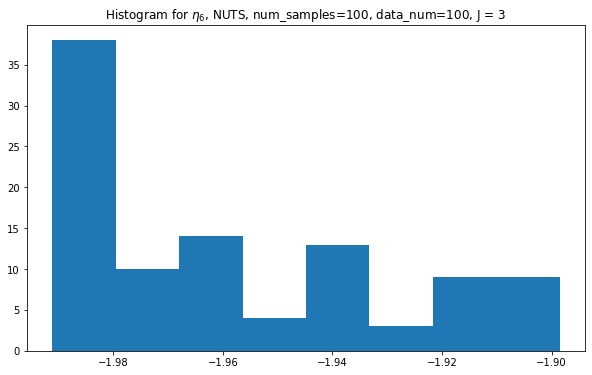

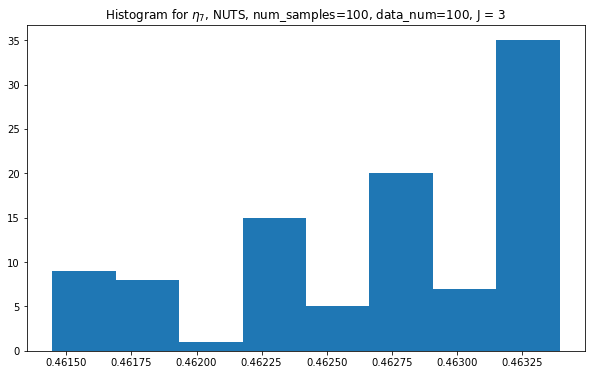

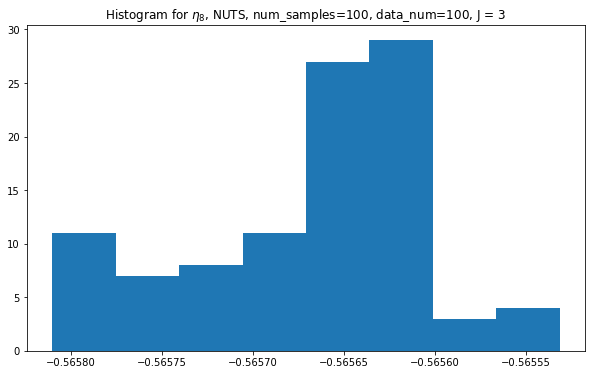

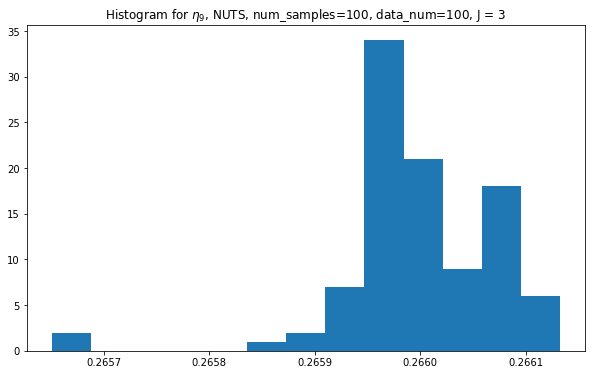

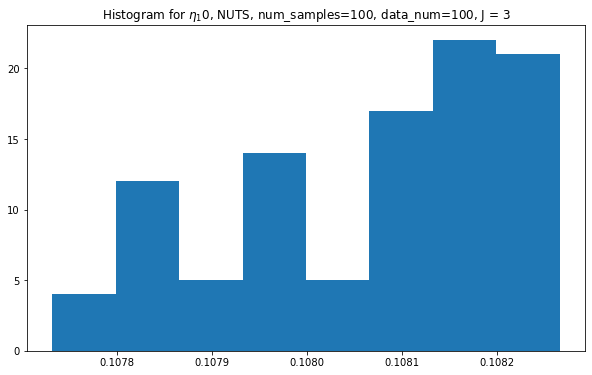

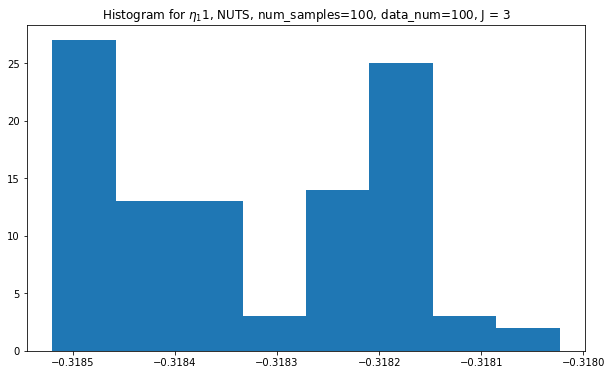

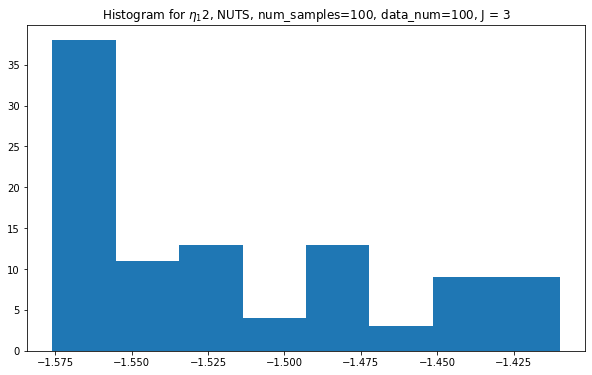

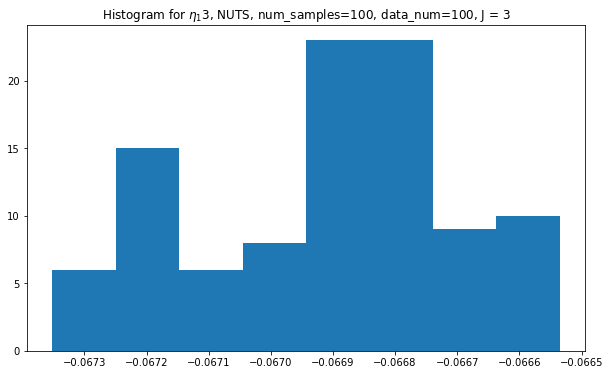

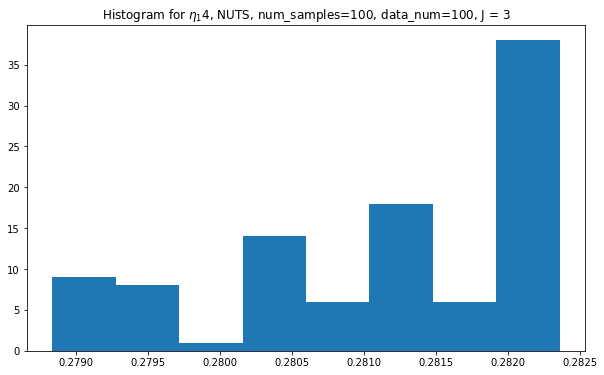

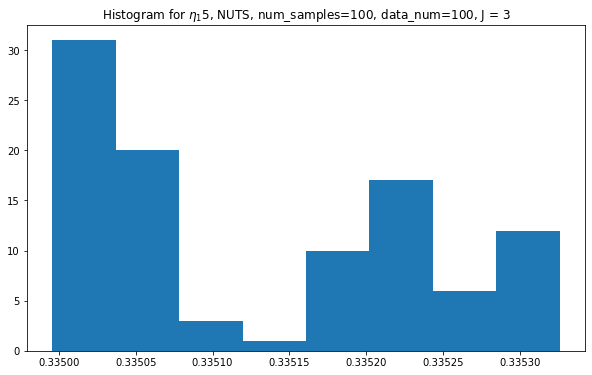

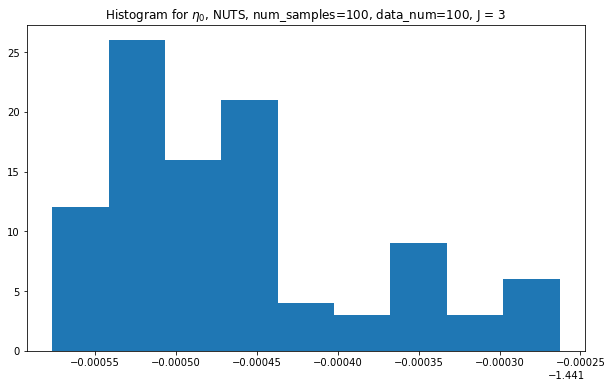

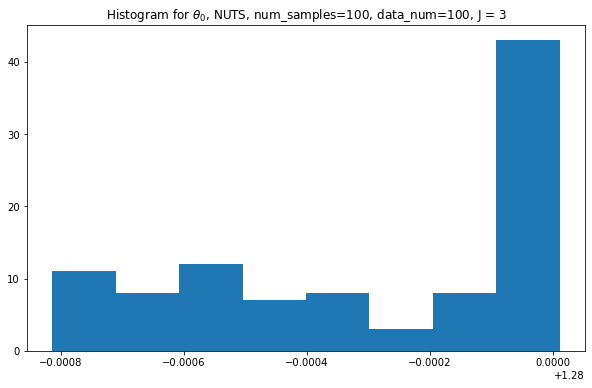

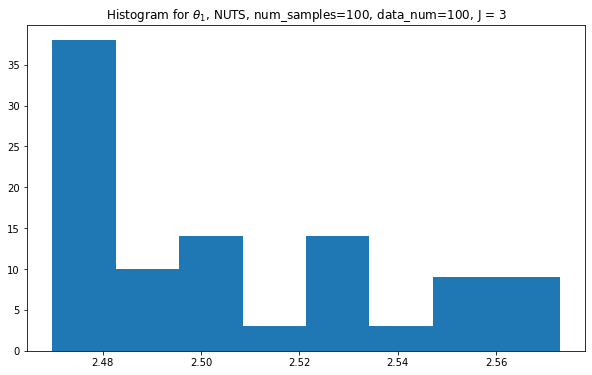

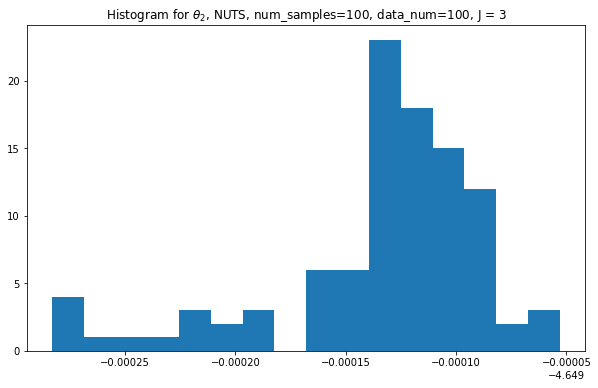

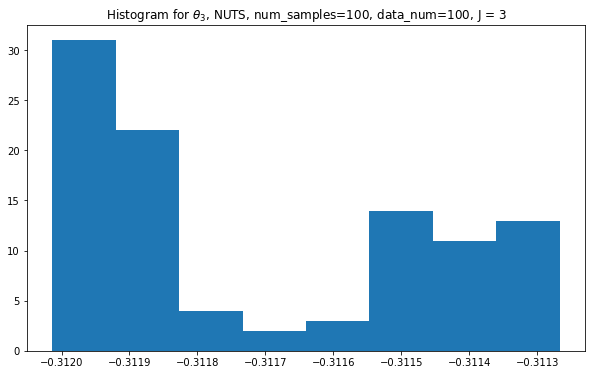

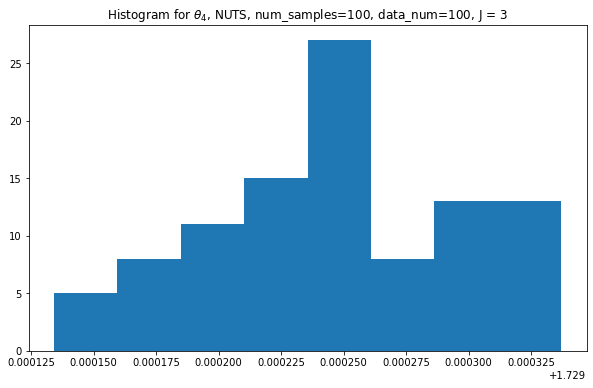

In [31]:
for i in range(params_dim):
    title_eta = fr"Histogram for $\eta_{i + 1}$, NUTS, num_samples={num_samples}, data_num={data_num_default}, J = 3"
    title_eta_0 = fr"Histogram for $\eta_{0}$, NUTS, num_samples={num_samples}, data_num={data_num_default}, J = 3"
    title_theta = fr"Histogram for $\theta_{i - 2**(J + 1)}$, NUTS, num_samples={num_samples}, "
    title_theta += fr"data_num={data_num_default}, J = 3"
    eta_save_name = f'../figures/nuts_num_samples_{num_samples}_eta_{i}' 
    eta_save_name += f'_data_num_{data_num_default}_J_3.png'
    eta_0_save_name = f'../figures/nuts_num_samples_{num_samples}_eta_0' 
    eta_0_save_name += f'_data_num_{data_num_default}_J_3.png'
    theta_save_name = f'../figures/nuts_num_samples_{num_samples}_theta_{i - 2**(J + 1)}' 
    theta_save_name += f'_data_num_{data_num_default}_J_3.png'
    fig = plt.figure(figsize=(10, 6)) 
    if (i < 2**(J + 1) - 1):
        a = np.load(f'../arrays/nuts_num_samples_{num_samples}_eta_{i + 1}_data_num_{data_num_default}_J_3.npy')
        plt.hist(a, bins='auto')
        plt.title(title_eta)
        plt.savefig(eta_save_name)
    if (i == 2**(J + 1) - 1):
        a = np.load(f'../arrays/nuts_num_samples_{num_samples}_eta_0_data_num_{data_num_default}_J_3.npy')
        plt.hist(a, bins='auto')
        plt.title(title_eta_0)
        plt.savefig(eta_0_save_name)
    if (i >= 2**(J + 1)):
        a = np.load(f'../arrays/nuts_num_samples_{num_samples}_theta_{i - 2**(J + 1)}_data_num_{data_num_default}_J_3.npy')
        plt.hist(a, bins='auto')
        plt.title(title_theta)
        plt.savefig(theta_save_name)
plt.show()